# HAT Clustering Analysis — Emotional vs Neutral (Per-Prompt Isolated)

Each data point is one permutation run — a full inference over a concatenated sequence of stories,
isolated via server reset + cache drop before each trial.

**Data layout per data point** (`runs/<label>/p<NNNN>/`):
```
perf_stat.csv        — 1ms buckets, 24 perf events (HAT Layer 1 tracepoints + Layer 2 PMU/power)
hat_interrupts.csv   — 100ms: /proc/interrupts, /proc/softirqs, CPU freq per core
proc_sample.csv      — 100ms: system + per-process CPU jiffies, RSS
collector_meta.json  — t0_ns, duration, perf_events list
trial_meta.json      — prompt_index, label, ok, t_request_start_ns, t_request_end_ns, elapsed_ms
```

**Experimental design:**
- 120 emotional permutations (5! orderings of 5 ptsd
 stories)
- 120 neutral permutations (5! orderings of 5 WikiHow articles)
- Neutral prompts are shorter on average → `elapsed_ms` used as a confounder proxy for prompt length
- Each trial is fully isolated: server reset + `drop_caches` + 2s stabilisation baseline

**Analysis approach:**
1. Extract 10 indicator metrics per HAT indicator (event-specific or PCI-specific, as appropriate)
2. Build a feature matrix: 240 rows × N metrics
3. Per-metric univariate screening (Mann-Whitney U + effect size)
4. Per-metric k=2 clustering → silhouette score → rank metrics by separability
5. Multi-metric GMM clustering on top-K features
6. Confounder check: elapsed_ms (prompt duration proxy for length difference)
7. PCoA / UMAP visualisation


In [7]:
import json, re, warnings
from pathlib import Path
from collections import defaultdict
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as sp_stats

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (14, 5)

print('Imports OK')

Imports OK


## 1 — Configuration

In [8]:
# ── Set this to your mccviahat root ──
BASE_DIR = Path.home() / 'Desktop' / 'mccviahat'

NEUTRAL_ROOT   = BASE_DIR / 'runs' / 'neutral' 
EMOTIONAL_ROOT = BASE_DIR / 'runs' / 'emotional'

for d in [NEUTRAL_ROOT, EMOTIONAL_ROOT]:
    assert d.exists(), f'Missing run root: {d}'

n_trials = sorted(NEUTRAL_ROOT.glob('p????'))
e_trials = sorted(EMOTIONAL_ROOT.glob('p????'))

print(f'Neutral trials:   {len(n_trials)}')
print(f'Emotional trials: {len(e_trials)}')

Neutral trials:   120
Emotional trials: 120


## 2 — Loaders

Each data point is a directory. We load:
- `perf_stat.csv` (wide format, 1ms resolution) — event-indicators + PCIs from perf
- `hat_interrupts.csv` (100ms) — cumulative /proc/interrupts counters, converted to deltas
- `trial_meta.json` — elapsed_ms (used as confounder for prompt length)

In [9]:
def load_trial_meta(trial_dir: Path) -> dict:
    p = trial_dir / 'trial_meta.json'
    return json.loads(p.read_text()) if p.exists() else {}


def load_collector_meta(trial_dir: Path) -> dict:
    p = trial_dir / 'collector_meta.json'
    return json.loads(p.read_text()) if p.exists() else {}


def load_perf(trial_dir: Path) -> pd.DataFrame | None:
    """Load perf_stat.csv (wide: t_s, event1, ...). Falls back to parsing perf_stat.txt."""
    csv_p = trial_dir / 'perf_stat.csv'
    txt_p = trial_dir / 'perf_stat.txt'
    if csv_p.exists() and csv_p.stat().st_size > 0:
        return pd.read_csv(csv_p)
    if txt_p.exists() and txt_p.stat().st_size > 0:
        return _parse_perf_txt(txt_p)
    return None


def _parse_perf_txt(path: Path) -> pd.DataFrame:
    """Parse perf stat -x ',' output into wide DataFrame."""
    from collections import OrderedDict
    rows_by_ts: dict = OrderedDict()
    events_seen: list = []
    for line in path.read_text(encoding='utf-8', errors='replace').splitlines():
        line = line.strip()
        if not line or line.startswith('#'):
            continue
        parts = line.split(',')
        if len(parts) < 4:
            continue
        try:
            ts = float(parts[0])
        except ValueError:
            continue
        event = parts[3].strip()
        if not event:
            continue
        val_s = parts[1].strip()
        val = float('nan') if (val_s.startswith('<') or val_s == '') else float(val_s) if val_s.replace('.','',1).isdigit() else float('nan')
        if event not in events_seen:
            events_seen.append(event)
        rows_by_ts.setdefault(ts, {})[event] = val
    records = [{'t_s': ts, **evts} for ts, evts in rows_by_ts.items()]
    df = pd.DataFrame(records).sort_values('t_s').reset_index(drop=True)
    return df


def load_hat_interrupts(trial_dir: Path) -> pd.DataFrame | None:
    """Load hat_interrupts.csv with cumulative counters converted to per-sample deltas."""
    p = trial_dir / 'hat_interrupts.csv'
    if not p.exists() or p.stat().st_size == 0:
        return None
    df = pd.read_csv(p)
    df['t_s'] = (df['timestamp_ns'] - df['timestamp_ns'].iloc[0]) / 1e9
    # Convert cumulative /proc/interrupts counts to deltas (rate per sample)
    irq_cols = [c for c in df.columns
                if c not in ('timestamp_ns', 't_s')
                and not c.endswith('_freq_khz')
                and pd.api.types.is_numeric_dtype(df[c])]
    for c in irq_cols:
        df[c] = df[c].diff().clip(lower=0)  # deltas; first row becomes NaN → drop later
    df = df.iloc[1:].reset_index(drop=True)  # drop first NaN row
    return df


print('Loaders defined')

Loaders defined


## 3 — Metric definitions

We compute **10 metrics** per indicator, split by indicator type:

| # | Metric | Applies to | Description |
|---|--------|------------|-------------|
| 1 | `mean_rate` | both | Mean count/value per time unit |
| 2 | `variance` | both (PCIs esp.) | Spread around the mean |
| 3 | `p90_p10` | both | Robust range (P90 − P10) |
| 4 | `slope` | PCIs esp. | Linear trend (drift during inference) |
| 5 | `spectral_entropy` | PCIs esp. | PSD entropy — structured vs broadband |
| 6 | `iat_cv` | event-indicators | Coefficient of variation of inter-arrival times |
| 7 | `burst_rate` | event-indicators | Bursts (runs > mean+1σ) per second |
| 8 | `burst_clustering` | event-indicators | Fraction of events inside bursts |
| 9 | `lz_complexity` | both | Lempel-Ziv complexity (binarised) |
| 10 | `perm_entropy` | both | Normalised permutation entropy (order=3) |

**Neutral prompts are shorter** → elapsed_ms differs systematically. We record it as a confounder
and use it to check that any detected separation is not purely a length artifact.

In [10]:
# ─── Metric helpers ───────────────────────────────────────────────────────────

def _safe(series: np.ndarray) -> np.ndarray:
    """Drop NaN/Inf, return float64."""
    s = np.asarray(series, dtype=float)
    return s[np.isfinite(s)]


def metric_mean_rate(s: np.ndarray, dt_s: float) -> float:
    """Mean count per second (event-indicators) or mean value (PCIs)."""
    s = _safe(s)
    return float(s.mean() / dt_s) if (len(s) > 0 and dt_s > 0) else np.nan


def metric_variance(s: np.ndarray) -> float:
    s = _safe(s)
    return float(np.var(s, ddof=1)) if len(s) > 1 else np.nan


def metric_p90_p10(s: np.ndarray) -> float:
    s = _safe(s)
    return float(np.percentile(s, 90) - np.percentile(s, 10)) if len(s) > 1 else np.nan


def metric_slope(s: np.ndarray) -> float:
    """OLS slope (value per sample)."""
    s = _safe(s)
    if len(s) < 3:
        return np.nan
    x = np.arange(len(s), dtype=float)
    return float(np.polyfit(x, s, 1)[0])


def metric_spectral_entropy(s: np.ndarray) -> float:
    """Normalised Shannon entropy of power spectral density."""
    s = _safe(s)
    if len(s) < 4:
        return np.nan
    psd = np.abs(np.fft.rfft(s - s.mean())) ** 2
    psd = psd[1:]  # skip DC
    if psd.sum() == 0:
        return 0.0
    p = psd / psd.sum()
    h = -np.sum(p * np.log2(p + 1e-15))
    return float(h / np.log2(len(p))) if len(p) > 1 else 0.0


def metric_iat_cv(s: np.ndarray) -> float:
    """CV of inter-arrival times (only meaningful for event-indicators)."""
    s = _safe(s)
    arrivals = np.where(s > 0)[0]
    if len(arrivals) < 3:
        return np.nan
    iat = np.diff(arrivals).astype(float)
    mu = iat.mean()
    return float(iat.std(ddof=1) / mu) if mu > 0 else np.nan


def metric_burst_rate(s: np.ndarray, dur_s: float) -> float:
    """Bursts (contiguous runs above mean+1σ) per second."""
    s = _safe(s)
    if len(s) < 2 or s.std() == 0:
        return 0.0
    thresh = s.mean() + s.std()
    above = (s > thresh).astype(int)
    diff = np.diff(np.concatenate(([0], above, [0])))
    n_bursts = int((diff == 1).sum())
    return float(n_bursts / dur_s) if dur_s > 0 else 0.0


def metric_burst_clustering(s: np.ndarray) -> float:
    """Fraction of total events that fall inside bursts."""
    s = _safe(s)
    if len(s) < 2 or s.std() == 0 or s.sum() == 0:
        return 0.0
    thresh = s.mean() + s.std()
    above = (s > thresh).astype(int)
    diff = np.diff(np.concatenate(([0], above, [0])))
    starts = np.where(diff == 1)[0]
    ends   = np.where(diff == -1)[0]
    if len(starts) == 0:
        return 0.0
    events_in_bursts = sum(s[st:en].sum() for st, en in zip(starts, ends))
    return float(events_in_bursts / s.sum())


def metric_lz_complexity(s: np.ndarray) -> float:
    """LZ76 complexity of binarised (> median) series, normalised."""
    s = _safe(s)
    if len(s) < 4:
        return np.nan
    binary = (s > np.median(s)).astype(int)
    seq = ''.join(map(str, binary))
    n = len(seq)
    i, k, l, c = 0, 1, 1, 1
    while k + l <= n:
        if seq[i + l - 1] == seq[k + l - 1]:
            l += 1
        else:
            i += 1
            if i == k:
                c += 1; k += l; i = 0; l = 1
            else:
                l = 1
    c += 1
    return float(c / (n / np.log2(n))) if n > 1 else 0.0


def metric_perm_entropy(s: np.ndarray, order: int = 3) -> float:
    """Normalised permutation entropy."""
    import math
    s = _safe(s)
    if len(s) < order:
        return np.nan
    counts = defaultdict(int)
    for i in range(len(s) - order + 1):
        counts[tuple(np.argsort(s[i:i+order]))] += 1
    total = sum(counts.values())
    probs = np.array(list(counts.values())) / total
    h = -np.sum(probs * np.log2(probs + 1e-15))
    h_max = np.log2(math.factorial(order))
    return float(h / h_max) if h_max > 0 else 0.0


def compute_all_metrics(s: np.ndarray, dur_s: float, indicator_type: str = 'event') -> dict:
    """
    Compute all 10 metrics for one indicator series.
    indicator_type: 'event' (discrete, irregular) or 'pci' (periodic, continuous).
    Both types get all 10 metrics; IAT-based ones return NaN for PCIs (constant interval).
    """
    return {
        'mean_rate':        metric_mean_rate(s, dur_s),
        'variance':         metric_variance(s),
        'p90_p10':          metric_p90_p10(s),
        'slope':            metric_slope(s),
        'spectral_entropy': metric_spectral_entropy(s),
        'iat_cv':           metric_iat_cv(s) if indicator_type == 'event' else np.nan,
        'burst_rate':       metric_burst_rate(s, dur_s),
        'burst_clustering': metric_burst_clustering(s),
        'lz_complexity':    metric_lz_complexity(s),
        'perm_entropy':     metric_perm_entropy(s),
    }


print('Metric functions defined')

Metric functions defined


## 4 — Feature extraction

Loop over all trials, load their perf and HAT interrupt data, compute metrics for each indicator.
One row = one trial = one data point.

In [11]:
# Classify perf events by indicator type
EVENT_INDICATORS = {
    'irq:irq_handler_entry', 'irq:irq_handler_exit',
    'irq:softirq_entry', 'irq:softirq_exit', 'irq:softirq_raise',
    'tlb:tlb_flush', 'mce:mce_record',
    'context-switches', 'cpu-migrations', 'page-faults',
}
# Everything else in perf is a PCI (counter read at fixed 1ms intervals)


def extract_trial_features(trial_dir: Path, label: str) -> dict | None:
    """Return a flat feature dict for one trial directory, or None on failure."""
    t_meta = load_trial_meta(trial_dir)
    if not t_meta.get('ok', False):
        return None  # failed trial

    perf = load_perf(trial_dir)
    if perf is None or len(perf) < 10:
        return None  # collector didn't produce usable data

    c_meta = load_collector_meta(trial_dir)
    dur_s = t_meta.get('elapsed_ms', np.nan) / 1000.0

    row = {
        'condition':   label,
        'prompt_index': t_meta.get('prompt_index', -1),
        'elapsed_ms':  t_meta.get('elapsed_ms', np.nan),
        'dur_s':       dur_s,
    }

    # ── perf indicators ──
    perf_events = [c for c in perf.columns if c != 't_s']
    for evt in perf_events:
        s = perf[evt].values.astype(float)
        itype = 'event' if evt in EVENT_INDICATORS else 'pci'
        metrics = compute_all_metrics(s, dur_s, itype)
        for m_name, m_val in metrics.items():
            row[f'{evt}__{m_name}'] = m_val

    # ── HAT interrupt indicators (delta counts at 100ms) ──
    hat = load_hat_interrupts(trial_dir)
    if hat is not None:
        hat_irq_cols = [c for c in hat.columns
                        if c not in ('timestamp_ns', 't_s')
                        and not c.endswith('_freq_khz')
                        and pd.api.types.is_numeric_dtype(hat[c])]
        hat_freq_cols = [c for c in hat.columns if c.endswith('_freq_khz')]

        for col in hat_irq_cols:
            s = hat[col].values.astype(float)
            metrics = compute_all_metrics(s, dur_s, 'event')
            for m_name, m_val in metrics.items():
                row[f'hat_{col}__{m_name}'] = m_val

        # CPU frequency: PCI at 100ms — mean and variance per trial
        if hat_freq_cols:
            freq_mean = hat[hat_freq_cols].mean(axis=1).values
            metrics = compute_all_metrics(freq_mean, dur_s, 'pci')
            for m_name, m_val in metrics.items():
                row[f'cpu_freq_mean__{m_name}'] = m_val

    return row


# ── Run extraction ──
print('Extracting features…')
records = []
skipped = 0

for trial_dir in n_trials:
    r = extract_trial_features(trial_dir, 'neutral')
    if r is not None:
        records.append(r)
    else:
        skipped += 1

for trial_dir in e_trials:
    r = extract_trial_features(trial_dir, 'emotional')
    if r is not None:
        records.append(r)
    else:
        skipped += 1

df_all = pd.DataFrame(records)
print(f'Loaded: {len(df_all)} trials ({skipped} skipped)')
print(f'  neutral:   {(df_all.condition == "neutral").sum()}')
print(f'  emotional: {(df_all.condition == "emotional").sum()}')
print(f'Feature columns: {len(df_all.columns) - 4}')

Extracting features…
Loaded: 240 trials (0 skipped)
  neutral:   120
  emotional: 120
Feature columns: 4980


## 5 — Confounder check: elapsed_ms

Neutral prompts are shorter. If elapsed_ms differs significantly between conditions,
any metric that scales with prompt duration is a confounder, not a true signal.
We check this explicitly and will flag length-sensitive metrics.

=== elapsed_ms (proxy for prompt length) ===
  Neutral:   mean=22342ms  std=173ms
  Emotional: mean=25553ms  std=201ms
  Mann-Whitney U p = 0.0000 ← LENGTH DIFFERS SIGNIFICANTLY


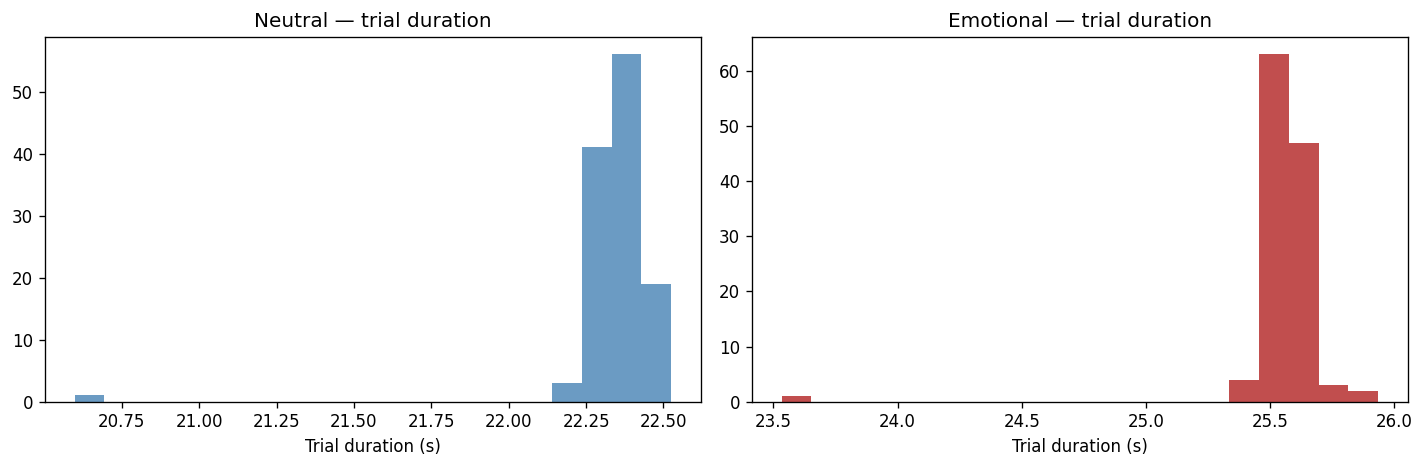


Length confound flag: True
Note: mean_rate is normalised by dur_s, so it is NOT confounded by length.
Metrics like burst_rate (per-second) are also duration-normalised.
Metrics like variance, p90_p10, lz_complexity may scale with duration → flag if sig.


In [12]:
n_rows = df_all[df_all.condition == 'neutral']
e_rows = df_all[df_all.condition == 'emotional']

print('=== elapsed_ms (proxy for prompt length) ===')
print(f'  Neutral:   mean={n_rows.elapsed_ms.mean():.0f}ms  std={n_rows.elapsed_ms.std():.0f}ms')
print(f'  Emotional: mean={e_rows.elapsed_ms.mean():.0f}ms  std={e_rows.elapsed_ms.std():.0f}ms')
stat, p_len = sp_stats.mannwhitneyu(n_rows.elapsed_ms, e_rows.elapsed_ms, alternative='two-sided')
print(f'  Mann-Whitney U p = {p_len:.4f}', '← LENGTH DIFFERS SIGNIFICANTLY' if p_len < 0.05 else '(OK, balanced)')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, rows, label, color in [
    (axes[0], n_rows, 'Neutral',   'steelblue'),
    (axes[1], e_rows, 'Emotional', 'firebrick'),
]:
    ax.hist(rows.elapsed_ms / 1000, bins=20, color=color, alpha=0.8)
    ax.set_xlabel('Trial duration (s)')
    ax.set_title(f'{label} — trial duration')
plt.tight_layout()
plt.show()

LENGTH_CONFOUNDED = p_len < 0.05
print(f'\nLength confound flag: {LENGTH_CONFOUNDED}')
print('Note: mean_rate is normalised by dur_s, so it is NOT confounded by length.')
print('Metrics like burst_rate (per-second) are also duration-normalised.')
print('Metrics like variance, p90_p10, lz_complexity may scale with duration → flag if sig.')

## 6 — Build feature matrix and clean

In [13]:
META_COLS = {'condition', 'prompt_index', 'elapsed_ms', 'dur_s'}
feat_cols = [c for c in df_all.columns if c not in META_COLS]

X_raw = df_all[feat_cols].copy()
y = (df_all['condition'] == 'emotional').astype(int).values  # 0=neutral, 1=emotional

# Drop zero-variance columns and fill NaN
X_raw = X_raw.loc[:, X_raw.std() > 0]
X_raw = X_raw.fillna(X_raw.median())

feat_cols = list(X_raw.columns)
print(f'Feature matrix: {X_raw.shape[0]} samples × {X_raw.shape[1]} features')

# Standardise
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X_raw), columns=feat_cols)
print('Standardised.')

Feature matrix: 240 samples × 1729 features
Standardised.


## 7 — Univariate screening: Mann-Whitney U per metric

Non-parametric test for each feature. We report effect size (rank-biserial r) and direction.

In [14]:
results = []
n_vals = X_raw[y == 0]
e_vals = X_raw[y == 1]

for col in feat_cols:
    nv = n_vals[col].dropna().values
    ev = e_vals[col].dropna().values
    if len(nv) < 5 or len(ev) < 5:
        continue
    if nv.std() == 0 and ev.std() == 0:
        continue
    stat, p = sp_stats.mannwhitneyu(nv, ev, alternative='two-sided')
    r = 1 - (2 * stat) / (len(nv) * len(ev))  # rank-biserial r
    results.append({
        'feature':   col,
        'U':         stat,
        'p':         p,
        'effect_r':  r,
        'n_mean':    nv.mean(),
        'e_mean':    ev.mean(),
        'direction': '↑E' if ev.mean() > nv.mean() else '↓E',
    })

mwu_df = pd.DataFrame(results).sort_values('p').reset_index(drop=True)

# Bonferroni-corrected threshold
alpha_raw = 0.05
alpha_bonf = alpha_raw / len(mwu_df)
sig_strict = mwu_df[mwu_df.p < alpha_bonf]
sig_nominal = mwu_df[mwu_df.p < alpha_raw]

print(f'Features tested: {len(mwu_df)}')
print(f'Significant at p<{alpha_raw} (nominal):    {len(sig_nominal)}')
print(f'Significant at p<{alpha_bonf:.2e} (Bonferroni): {len(sig_strict)}')
print()
print('=== Top 30 features by p-value ===')
print(mwu_df.head(30)[['feature', 'U', 'p', 'effect_r', 'direction']].to_string(
    index=False, float_format='{:.4f}'.format))

Features tested: 1729
Significant at p<0.05 (nominal):    837
Significant at p<2.89e-05 (Bonferroni): 616

=== Top 30 features by p-value ===
               feature          U      p  effect_r direction
hat_697__lz_complexity 14400.0000 0.0000   -1.0000        ↓E
hat_627__lz_complexity 14400.0000 0.0000   -1.0000        ↓E
hat_628__lz_complexity 14400.0000 0.0000   -1.0000        ↓E
hat_685__lz_complexity 14400.0000 0.0000   -1.0000        ↓E
hat_686__lz_complexity 14400.0000 0.0000   -1.0000        ↓E
hat_339__lz_complexity 14400.0000 0.0000   -1.0000        ↓E
hat_688__lz_complexity 14400.0000 0.0000   -1.0000        ↓E
hat_689__lz_complexity 14400.0000 0.0000   -1.0000        ↓E
hat_690__lz_complexity 14400.0000 0.0000   -1.0000        ↓E
hat_691__lz_complexity 14400.0000 0.0000   -1.0000        ↓E
hat_692__lz_complexity 14400.0000 0.0000   -1.0000        ↓E
hat_693__lz_complexity 14400.0000 0.0000   -1.0000        ↓E
hat_694__lz_complexity 14400.0000 0.0000   -1.0000        ↓E
hat_

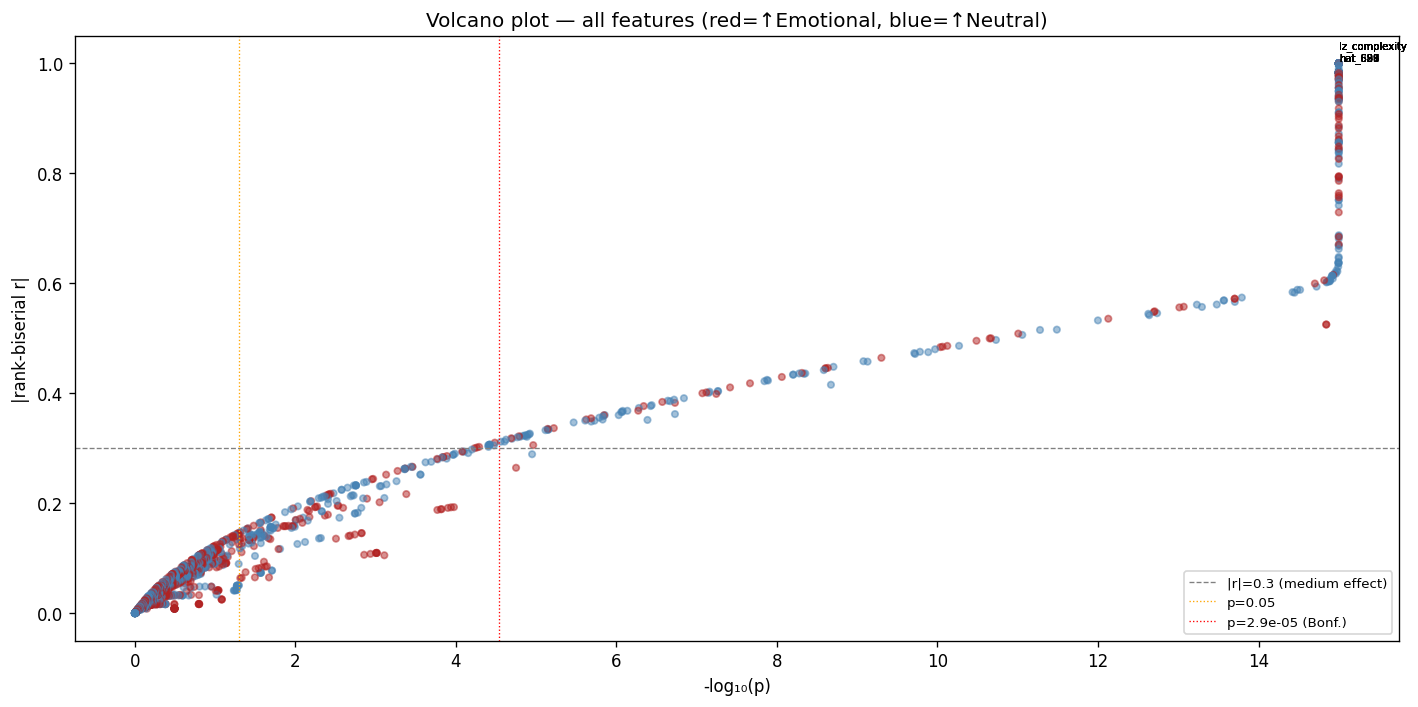

In [15]:
# Volcano plot: effect size vs -log10(p)
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['firebrick' if r > 0 else 'steelblue' for r in mwu_df.effect_r]
ax.scatter(-np.log10(mwu_df.p + 1e-15), mwu_df.effect_r.abs(),
           c=colors, alpha=0.5, s=15)
ax.axhline(0.3, ls='--', color='gray', lw=0.8, label='|r|=0.3 (medium effect)')
ax.axvline(-np.log10(alpha_raw), ls=':', color='orange', lw=0.8, label=f'p={alpha_raw}')
ax.axvline(-np.log10(alpha_bonf), ls=':', color='red', lw=0.8, label=f'p={alpha_bonf:.1e} (Bonf.)')
# Label top 10
for _, row in mwu_df.head(10).iterrows():
    ax.annotate(row.feature.split('__')[-1] + '\n' + row.feature.split('__')[0][:15],
                xy=(-np.log10(row.p + 1e-15), abs(row.effect_r)),
                fontsize=6, ha='left', va='bottom')
ax.set_xlabel('-log₁₀(p)')
ax.set_ylabel('|rank-biserial r|')
ax.set_title('Volcano plot — all features (red=↑Emotional, blue=↑Neutral)')
ax.legend(fontsize=8)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_volcano.png', dpi=150, bbox_inches='tight')
plt.show()

## 8 — Per-metric k=2 clustering → silhouette ranking

For each feature independently, fit k-means with k=2 and score how well the
resulting clusters align with the ground-truth labels.

Two scores per feature:
- **Silhouette**: geometric cluster quality (−1 to 1, higher = more separated)
- **ARI** (Adjusted Rand Index): overlap with true labels (0=random, 1=perfect)

In [16]:
cluster_results = []

for col in feat_cols:
    x1d = X[[col]].values
    if np.isnan(x1d).any():
        continue
    km = KMeans(n_clusters=2, random_state=42, n_init=10)
    labels_pred = km.fit_predict(x1d)
    sil = silhouette_score(x1d, labels_pred)
    ari = adjusted_rand_score(y, labels_pred)
    # Cluster purity: fraction of majority label in each cluster
    mask0 = labels_pred == 0
    mask1 = labels_pred == 1
    purity = max(
        (y[mask0] == 0).mean() if mask0.sum() > 0 else 0,
        (y[mask0] == 1).mean() if mask0.sum() > 0 else 0,
    ) * 0.5 + max(
        (y[mask1] == 0).mean() if mask1.sum() > 0 else 0,
        (y[mask1] == 1).mean() if mask1.sum() > 0 else 0,
    ) * 0.5
    cluster_results.append({
        'feature':   col,
        'silhouette': sil,
        'ari':       ari,
        'purity':    purity,
    })

clust_df = pd.DataFrame(cluster_results).sort_values('silhouette', ascending=False).reset_index(drop=True)
print('=== Top 30 features by silhouette score ===')
print(clust_df.head(30).to_string(index=False, float_format='{:.4f}'.format))

=== Top 30 features by silhouette score ===
                     feature  silhouette     ari  purity
   hat_447__burst_clustering      1.0000  0.0137  0.5679
   hat_533__burst_clustering      1.0000 -0.0024  0.5210
   hat_532__burst_clustering      1.0000 -0.0030  0.5168
   hat_531__burst_clustering      1.0000  0.0139  0.5705
   hat_530__burst_clustering      1.0000  0.0003  0.5337
   hat_556__burst_clustering      1.0000 -0.0039  0.5044
   hat_529__burst_clustering      1.0000 -0.0007  0.5296
   hat_528__burst_clustering      1.0000  0.0004  0.5345
   hat_MCP__burst_clustering      1.0000 -0.0009  0.5300
   hat_527__burst_clustering      1.0000  0.0028  0.5424
   hat_525__burst_clustering      1.0000  0.0332  0.6100
   hat_557__burst_clustering      1.0000 -0.0038  0.5086
   hat_IWI__burst_clustering      1.0000 -0.0003  0.5330
   hat_524__burst_clustering      1.0000  0.0162  0.5746
   hat_558__burst_clustering      1.0000  0.0044  0.5483
   hat_523__burst_clustering      1.0000  0.

In [17]:
# Combine MWU p-value and silhouette into one ranking table
ranking = mwu_df[['feature', 'p', 'effect_r', 'direction']].merge(
    clust_df[['feature', 'silhouette', 'ari', 'purity']], on='feature', how='inner')

# Composite score: (1 - normalised_p_rank) * 0.5 + silhouette_rank * 0.5
ranking['p_rank']   = ranking['p'].rank()
ranking['sil_rank'] = (-ranking['silhouette']).rank()  # lower is better
ranking['composite_rank'] = ranking[['p_rank', 'sil_rank']].mean(axis=1)
ranking = ranking.sort_values('composite_rank').reset_index(drop=True)

print('=== Combined ranking (MWU + silhouette) — top 30 ===')
print(ranking.head(30)[['feature','p','effect_r','direction','silhouette','ari','purity']]
      .to_string(index=False, float_format='{:.4f}'.format))

# Save full ranking
ranking.to_csv(BASE_DIR / 'metric_ranking.csv', index=False)
print(f'\nSaved → {BASE_DIR}/metric_ranking.csv')

=== Combined ranking (MWU + silhouette) — top 30 ===
                   feature      p  effect_r direction  silhouette     ari  purity
    hat_246__lz_complexity 0.0000   -0.9347        ↑E      0.9901  0.0000  0.7510
 hat_548__burst_clustering 0.0004    0.2167        ↑E      1.0000  0.0433  0.6204
 hat_563__burst_clustering 0.0013    0.2083        ↑E      1.0000  0.0394  0.6042
 hat_525__burst_clustering 0.0015   -0.1917        ↓E      1.0000  0.0332  0.6100
 hat_560__burst_clustering 0.0025    0.1917        ↑E      1.0000  0.0328  0.5995
 hat_227__burst_clustering 0.0000   -0.2892        ↓E      0.9970  0.0913  0.6543
hat_HRTIMER__lz_complexity 0.0000   -0.9833        ↓E      0.9752  0.0000  0.7510
 hat_536__burst_clustering 0.0067    0.1750        ↑E      1.0000  0.0266  0.5880
 hat_236__burst_clustering 0.0009    0.2017        ↑E      0.9993  0.0365  0.6140
    hat_260__lz_complexity 0.0000   -0.6368        ↑E      0.9839  0.0000  0.7510
 hat_242__burst_clustering 0.0001    0.1929  

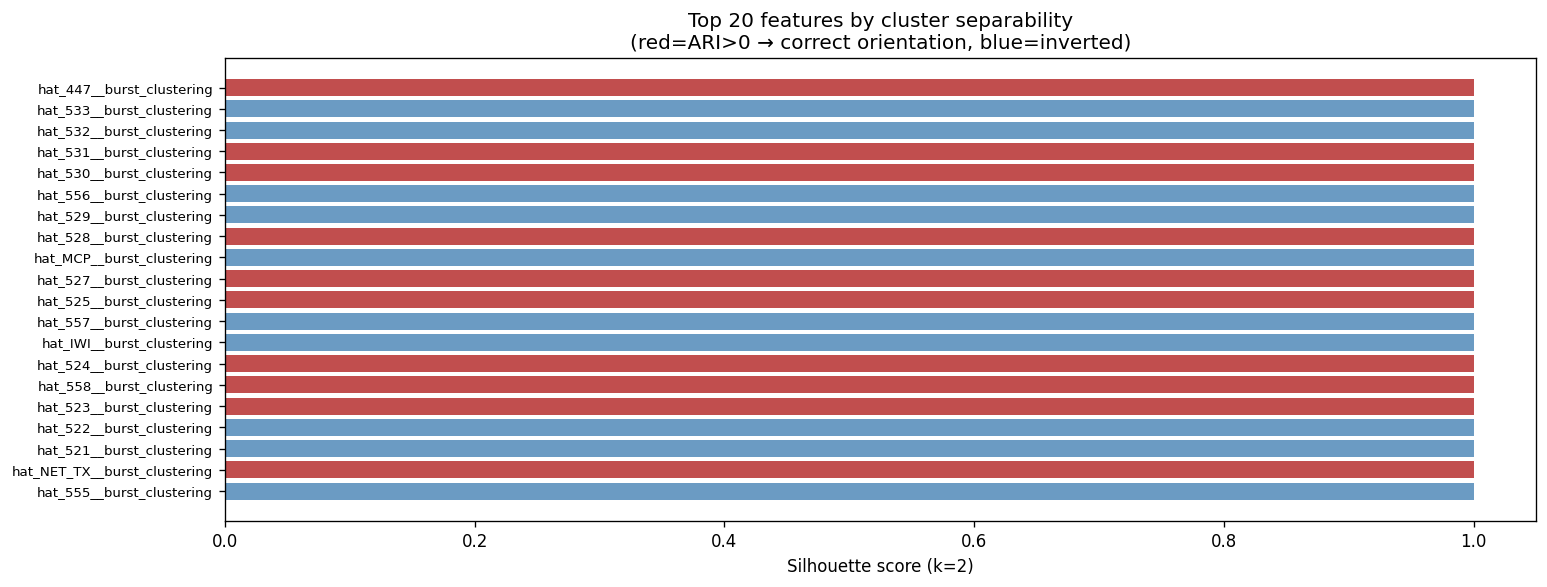

In [18]:
# Bar chart: top 20 features by silhouette
top20 = clust_df.head(20)
fig, ax = plt.subplots(figsize=(13, 5))
colors = ['firebrick' if row.ari > 0 else 'steelblue'
          for _, row in top20.iterrows()]
ax.barh(range(len(top20)), top20.silhouette, color=colors, alpha=0.8)
ax.set_yticks(range(len(top20)))
ax.set_yticklabels(top20.feature, fontsize=8)
ax.invert_yaxis()
ax.set_xlabel('Silhouette score (k=2)')
ax.set_title('Top 20 features by cluster separability\n(red=ARI>0 → correct orientation, blue=inverted)')
ax.axvline(0, color='black', lw=0.5)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_silhouette_ranking.png', dpi=150, bbox_inches='tight')
plt.show()

## 9 — Per-indicator metric summary

Which metric type (mean_rate, variance, burst_clustering, …) drives the most separable features?
Aggregate silhouette scores by metric suffix.

=== Metric type summary ===
          metric  n_features  mean_sil  max_sil  mean_ari               best_feature
burst_clustering         154    0.9353   1.0000    0.0400  hat_447__burst_clustering
spectral_entropy         156    0.9328   1.0000    0.0131  hat_MCP__spectral_entropy
          iat_cv         105    0.9307   0.9958    0.0011            hat_249__iat_cv
        variance         156    0.9193   0.9986    0.0303      hat_TASKLET__variance
   lz_complexity         496    0.9163   0.9915    0.6944 hat_TASKLET__lz_complexity
       mean_rate         156    0.9032   0.9958    0.1302     hat_HRTIMER__mean_rate
           slope         156    0.8736   0.9958    0.0399         hat_HRTIMER__slope
         p90_p10          38    0.8620   0.9981    0.0468           hat_542__p90_p10
      burst_rate         156    0.8497   0.9974    0.0464        hat_152__burst_rate
    perm_entropy         156    0.8092   0.9978    0.0210      hat_153__perm_entropy


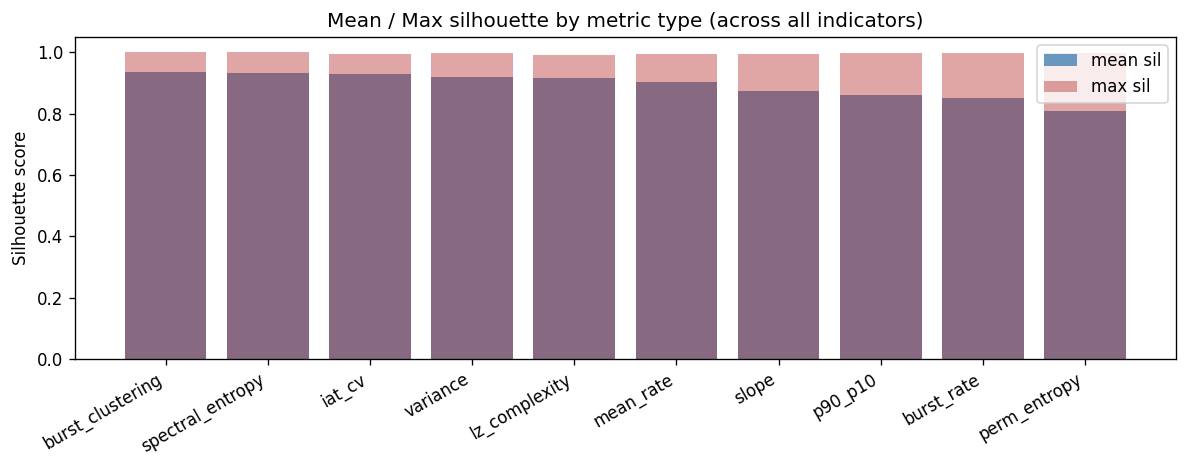

In [19]:
METRIC_NAMES = ['mean_rate','variance','p90_p10','slope','spectral_entropy',
                'iat_cv','burst_rate','burst_clustering','lz_complexity','perm_entropy']

metric_agg = []
for m in METRIC_NAMES:
    rows = clust_df[clust_df.feature.str.endswith(f'__{m}')]
    if len(rows) == 0:
        continue
    metric_agg.append({
        'metric':       m,
        'n_features':   len(rows),
        'mean_sil':     rows.silhouette.mean(),
        'max_sil':      rows.silhouette.max(),
        'mean_ari':     rows.ari.mean(),
        'best_feature': rows.iloc[0].feature,
    })

metric_agg_df = pd.DataFrame(metric_agg).sort_values('mean_sil', ascending=False)
print('=== Metric type summary ===')
print(metric_agg_df.to_string(index=False, float_format='{:.4f}'.format))

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(metric_agg_df.metric, metric_agg_df.mean_sil, alpha=0.8, color='steelblue', label='mean sil')
ax.bar(metric_agg_df.metric, metric_agg_df.max_sil, alpha=0.4, color='firebrick', label='max sil')
ax.set_ylabel('Silhouette score')
ax.set_title('Mean / Max silhouette by metric type (across all indicators)')
ax.legend()
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_metric_type_summary.png', dpi=150, bbox_inches='tight')
plt.show()

## 10 — GMM clustering on top-K features

Select the top K features by composite rank, fit a 2-component GMM, and evaluate
cluster assignment against ground-truth labels.

In [23]:
TOP_K = 24 # adjust after inspecting ranking

top_features = ranking.head(TOP_K)['feature'].tolist()
X_top = X[top_features].values

# GMM with k=2
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42, n_init=10)
gmm.fit(X_top)
gmm_labels = gmm.predict(X_top)
gmm_probs  = gmm.predict_proba(X_top)

ari_gmm  = adjusted_rand_score(y, gmm_labels)
sil_gmm  = silhouette_score(X_top, gmm_labels)

# Align GMM label 0/1 to neutral/emotional
# (GMM labels are arbitrary — check which assignment gives better accuracy)
acc_direct  = (gmm_labels == y).mean()
acc_flipped = (1 - gmm_labels == y).mean()
if acc_flipped > acc_direct:
    gmm_labels = 1 - gmm_labels
    gmm_probs  = gmm_probs[:, ::-1]
accuracy = (gmm_labels == y).mean()

print(f'GMM (k=2) on top {TOP_K} features:')
print(f'  ARI:      {ari_gmm:.4f}')
print(f'  Silhouette: {sil_gmm:.4f}')
print(f'  Accuracy vs ground truth: {accuracy:.1%}')
print(f'  Neutral correctly assigned:   {(gmm_labels[y==0] == 0).mean():.1%}')
print(f'  Emotional correctly assigned: {(gmm_labels[y==1] == 1).mean():.1%}')

GMM (k=2) on top 24 features:
  ARI:      0.9342
  Silhouette: 0.0913
  Accuracy vs ground truth: 98.3%
  Neutral correctly assigned:   98.3%
  Emotional correctly assigned: 98.3%


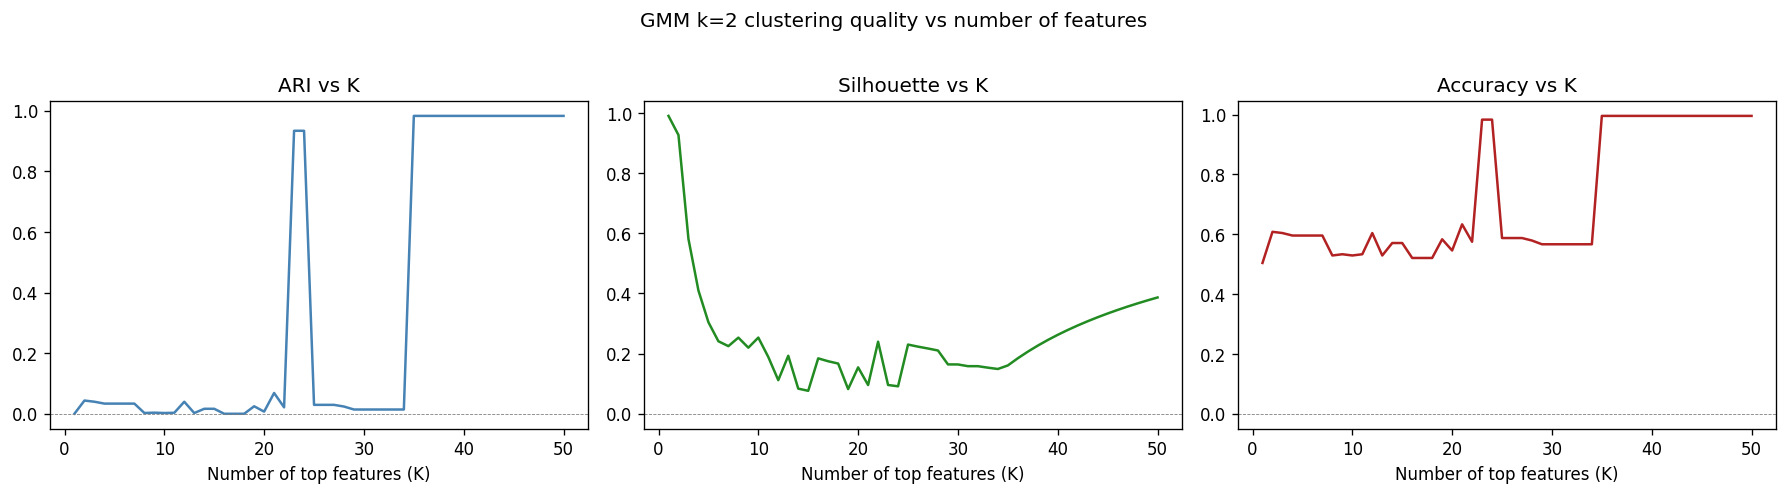

In [21]:
# Sweep K from 1 to 50: how does clustering quality scale with number of features?
K_vals = list(range(1, min(51, len(feat_cols) + 1)))
ari_vals, sil_vals, acc_vals = [], [], []

for k in K_vals:
    feats = ranking.head(k)['feature'].tolist()
    Xk = X[feats].values
    try:
        gmm_k = GaussianMixture(n_components=2, covariance_type='full', random_state=42, n_init=5)
        lbl = gmm_k.fit_predict(Xk)
        ari_k = adjusted_rand_score(y, lbl)
        sil_k = silhouette_score(Xk, lbl) if len(np.unique(lbl)) > 1 else 0.0
        acc_k = max((lbl == y).mean(), (1 - lbl == y).mean())
        ari_vals.append(ari_k); sil_vals.append(sil_k); acc_vals.append(acc_k)
    except Exception:
        ari_vals.append(np.nan); sil_vals.append(np.nan); acc_vals.append(np.nan)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, vals, title, color in [
    (axes[0], ari_vals,  'ARI vs K',        'steelblue'),
    (axes[1], sil_vals,  'Silhouette vs K', 'forestgreen'),
    (axes[2], acc_vals,  'Accuracy vs K',   'firebrick'),
]:
    ax.plot(K_vals, vals, color=color, lw=1.5)
    ax.axhline(0, color='gray', lw=0.5, ls='--')
    ax.set_xlabel('Number of top features (K)')
    ax.set_title(title)

plt.suptitle('GMM k=2 clustering quality vs number of features', fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_k_sweep.png', dpi=150, bbox_inches='tight')
plt.show()

## 11 — PCA visualisation of cluster structure

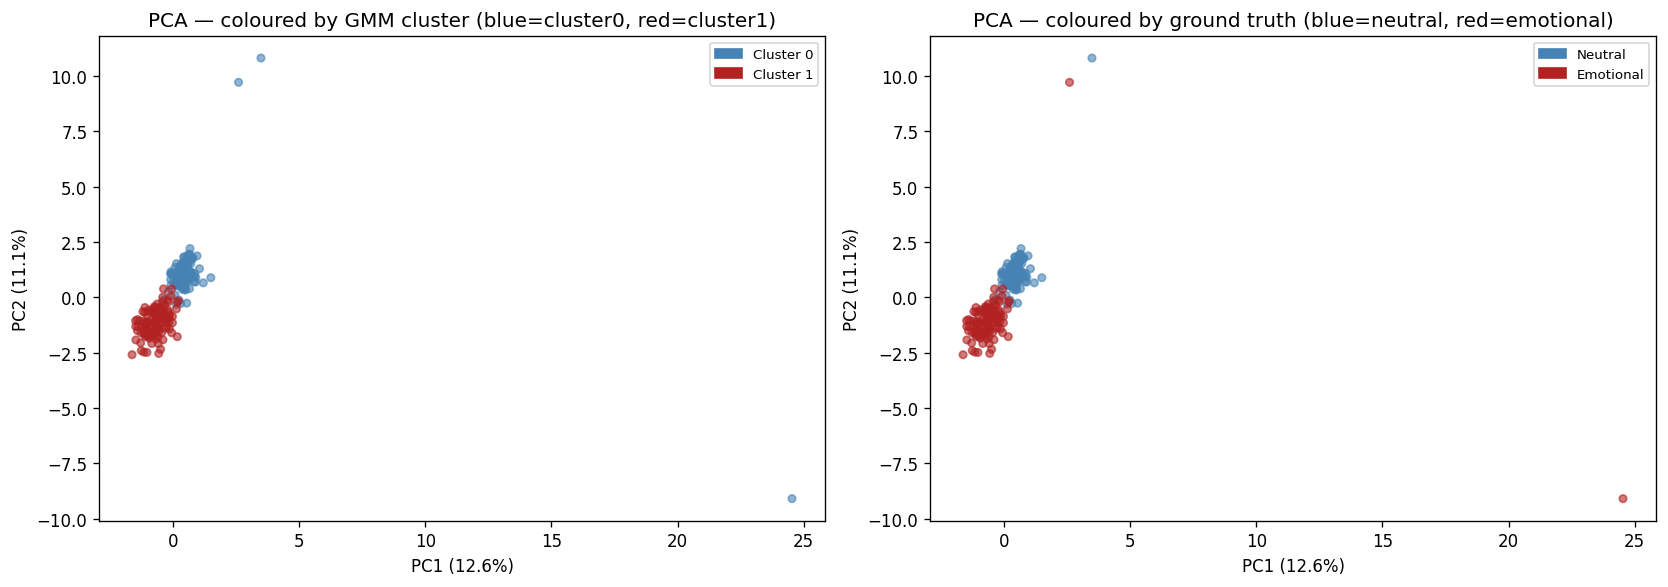

PCA explained variance: PC1=12.6%, PC2=11.1%


In [24]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X[top_features].values)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: colour by GMM cluster assignment
ax = axes[0]
colors_pred = ['steelblue' if l == 0 else 'firebrick' for l in gmm_labels]
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=colors_pred, alpha=0.6, s=20)
ax.set_title('PCA — coloured by GMM cluster (blue=cluster0, red=cluster1)')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')

# Right: colour by ground truth
ax = axes[1]
gt_colors = ['steelblue' if yi == 0 else 'firebrick' for yi in y]
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=gt_colors, alpha=0.6, s=20)
ax.set_title('PCA — coloured by ground truth (blue=neutral, red=emotional)')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')

# Custom legends
from matplotlib.patches import Patch
axes[0].legend(handles=[Patch(color='steelblue', label='Cluster 0'),
                         Patch(color='firebrick', label='Cluster 1')], fontsize=8)
axes[1].legend(handles=[Patch(color='steelblue', label='Neutral'),
                         Patch(color='firebrick', label='Emotional')], fontsize=8)

plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_pca_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'PCA explained variance: PC1={pca.explained_variance_ratio_[0]:.1%}, PC2={pca.explained_variance_ratio_[1]:.1%}')

## 12 — Feature correlation matrix (top features)

Identify redundant features. Correlated features (|r|>0.9) carry overlapping information
and should be pruned to one representative per cluster.

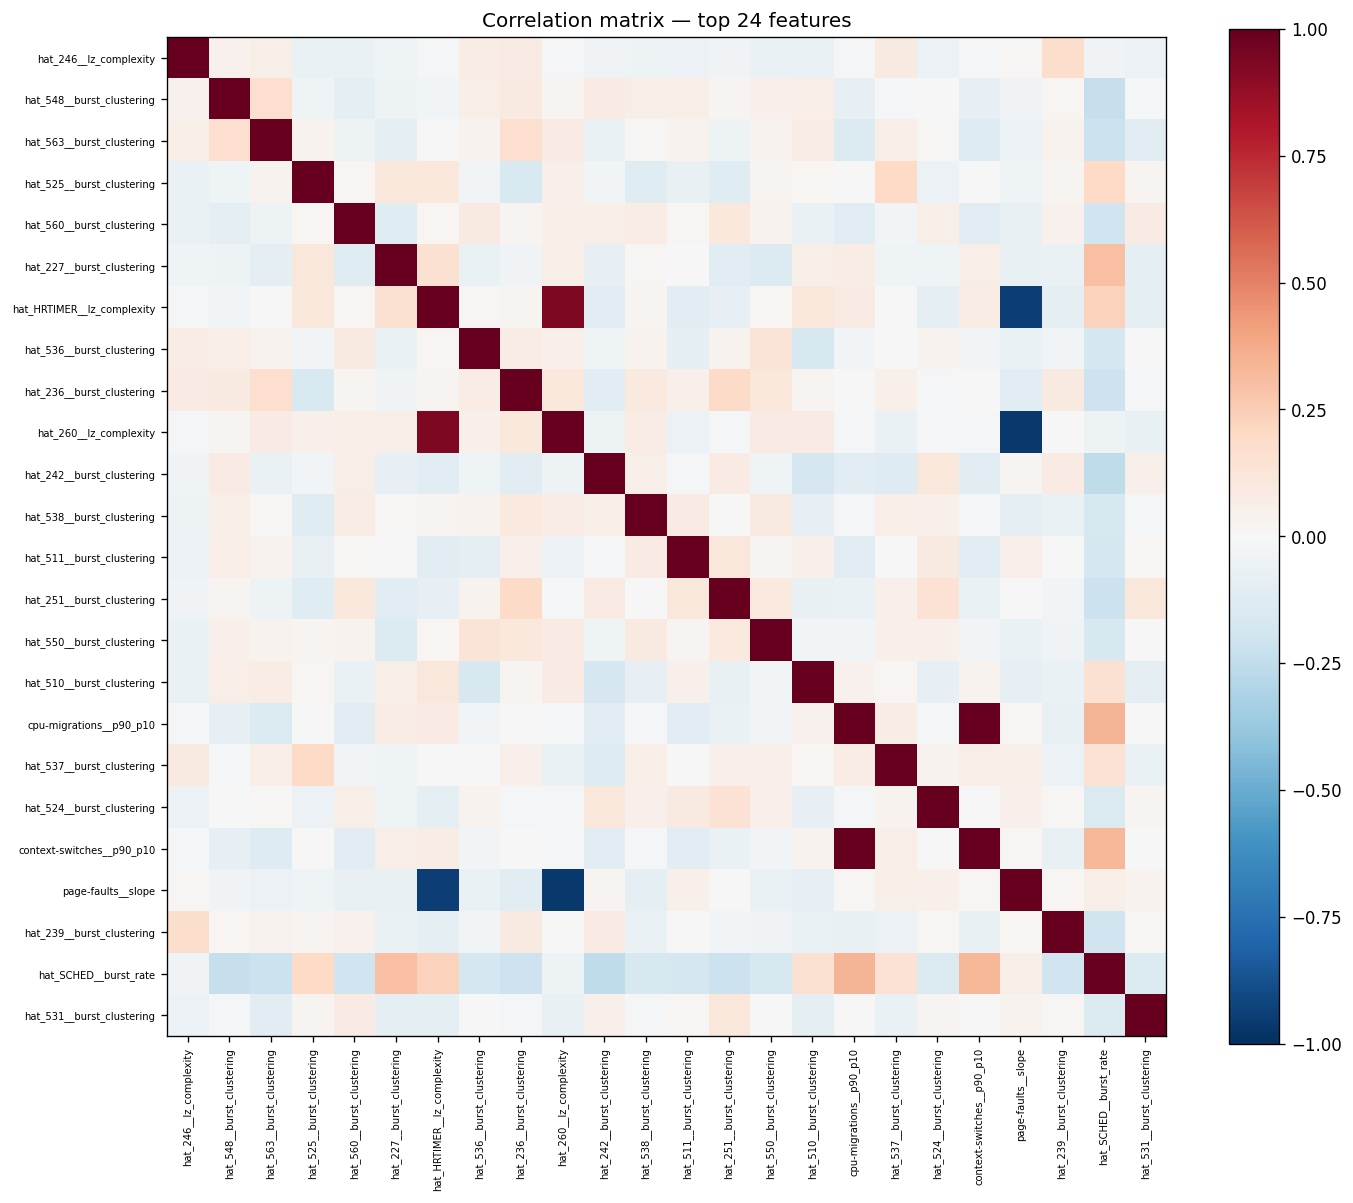

Highly correlated pairs (|r|>0.9): 4
                 feature_A                 feature_B      r
hat_HRTIMER__lz_complexity    hat_260__lz_complexity  0.933
hat_HRTIMER__lz_complexity        page-faults__slope -0.944
    hat_260__lz_complexity        page-faults__slope -0.962
   cpu-migrations__p90_p10 context-switches__p90_p10  0.999


In [25]:
CORR_TOP = min(30, len(top_features))
corr = X[ranking.head(CORR_TOP)['feature'].tolist()].corr()

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(corr.values, vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar(im, ax=ax)
ax.set_xticks(range(CORR_TOP))
ax.set_yticks(range(CORR_TOP))
ax.set_xticklabels(corr.columns, rotation=90, fontsize=6)
ax.set_yticklabels(corr.index, fontsize=6)
ax.set_title(f'Correlation matrix — top {CORR_TOP} features')
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

# Report highly correlated pairs
high_corr = []
cols = list(corr.columns)
for i, a in enumerate(cols):
    for j, b in enumerate(cols):
        if j <= i:
            continue
        r = corr.loc[a, b]
        if abs(r) > 0.9:
            high_corr.append({'feature_A': a, 'feature_B': b, 'r': r})
if high_corr:
    print(f'Highly correlated pairs (|r|>0.9): {len(high_corr)}')
    print(pd.DataFrame(high_corr).to_string(index=False, float_format='{:.3f}'.format))
else:
    print('No highly correlated pairs among top features.')

## 13 — Per-indicator: which metrics drive each indicator?

For each HAT indicator, show which of the 10 metrics has the best silhouette.
This tells you not just *that* an indicator differs, but *how* it differs.

=== Best metric per indicator (top 30 by silhouette) ===
indicator           metric  silhouette     ari
  hat_249 burst_clustering      1.0000 -0.0017
  hat_552 burst_clustering      1.0000  0.0034
  hat_561 burst_clustering      1.0000 -0.0015
  hat_560 burst_clustering      1.0000  0.0328
  hat_559 burst_clustering      1.0000 -0.0038
  hat_558 burst_clustering      1.0000  0.0044
  hat_557 burst_clustering      1.0000 -0.0038
  hat_556 burst_clustering      1.0000 -0.0039
  hat_555 burst_clustering      1.0000 -0.0041
  hat_554 burst_clustering      1.0000 -0.0007
  hat_553 burst_clustering      1.0000 -0.0035
  hat_551 burst_clustering      1.0000  0.0116
  hat_563 burst_clustering      1.0000  0.0394
  hat_550 burst_clustering      1.0000  0.0210
  hat_549 burst_clustering      1.0000 -0.0040
  hat_548 burst_clustering      1.0000  0.0433
  hat_547 burst_clustering      1.0000 -0.0038
  hat_546 burst_clustering      1.0000 -0.0039
  hat_545 burst_clustering      1.0000 -0.0006
  h

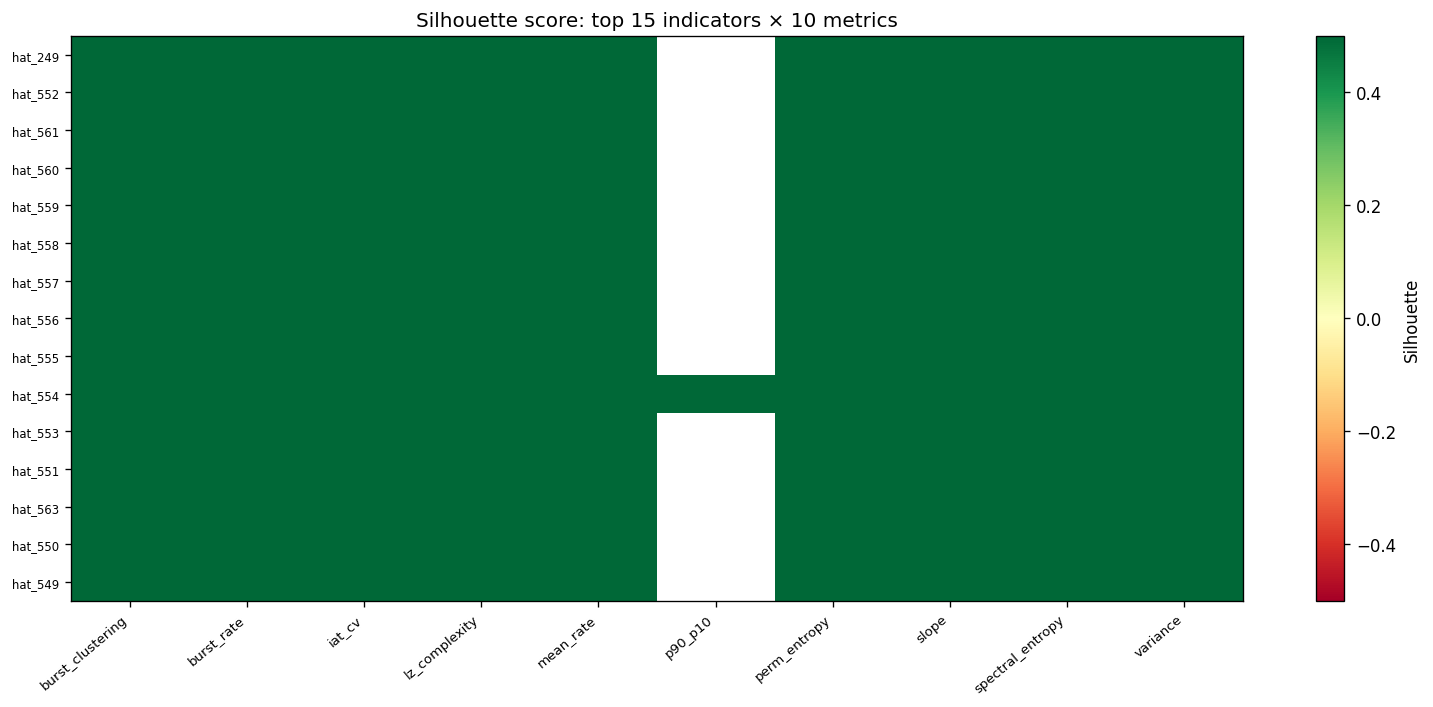

In [26]:
# Parse feature names: indicator__metric
def parse_feature(fname):
    parts = fname.rsplit('__', 1)
    if len(parts) == 2:
        return parts[0], parts[1]
    return fname, ''

clust_df['indicator'] = clust_df.feature.apply(lambda f: parse_feature(f)[0])
clust_df['metric']    = clust_df.feature.apply(lambda f: parse_feature(f)[1])

# Best metric per indicator
best_per_ind = (clust_df
    .sort_values('silhouette', ascending=False)
    .groupby('indicator')
    .first()
    .reset_index()
    [['indicator', 'metric', 'silhouette', 'ari']]
    .sort_values('silhouette', ascending=False)
)

print('=== Best metric per indicator (top 30 by silhouette) ===')
print(best_per_ind.head(30).to_string(index=False, float_format='{:.4f}'.format))

# Heatmap: indicators × metrics, silhouette value
top_inds = best_per_ind.head(15)['indicator'].tolist()
pivot = clust_df[clust_df.indicator.isin(top_inds)].pivot_table(
    index='indicator', columns='metric', values='silhouette', aggfunc='first')
pivot = pivot.reindex(index=top_inds)

fig, ax = plt.subplots(figsize=(13, 6))
im = ax.imshow(pivot.values, cmap='RdYlGn', vmin=-0.5, vmax=0.5, aspect='auto')
plt.colorbar(im, ax=ax, label='Silhouette')
ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels(pivot.columns, rotation=40, ha='right', fontsize=8)
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels([s[:40] for s in pivot.index], fontsize=7)
ax.set_title('Silhouette score: top 15 indicators × 10 metrics')
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_indicator_metric_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 14 — Final: single-metric distribution plots for top features

For the top 6 features by composite rank, show overlapping KDEs for
neutral vs emotional — the visual confirmation of cluster separation.

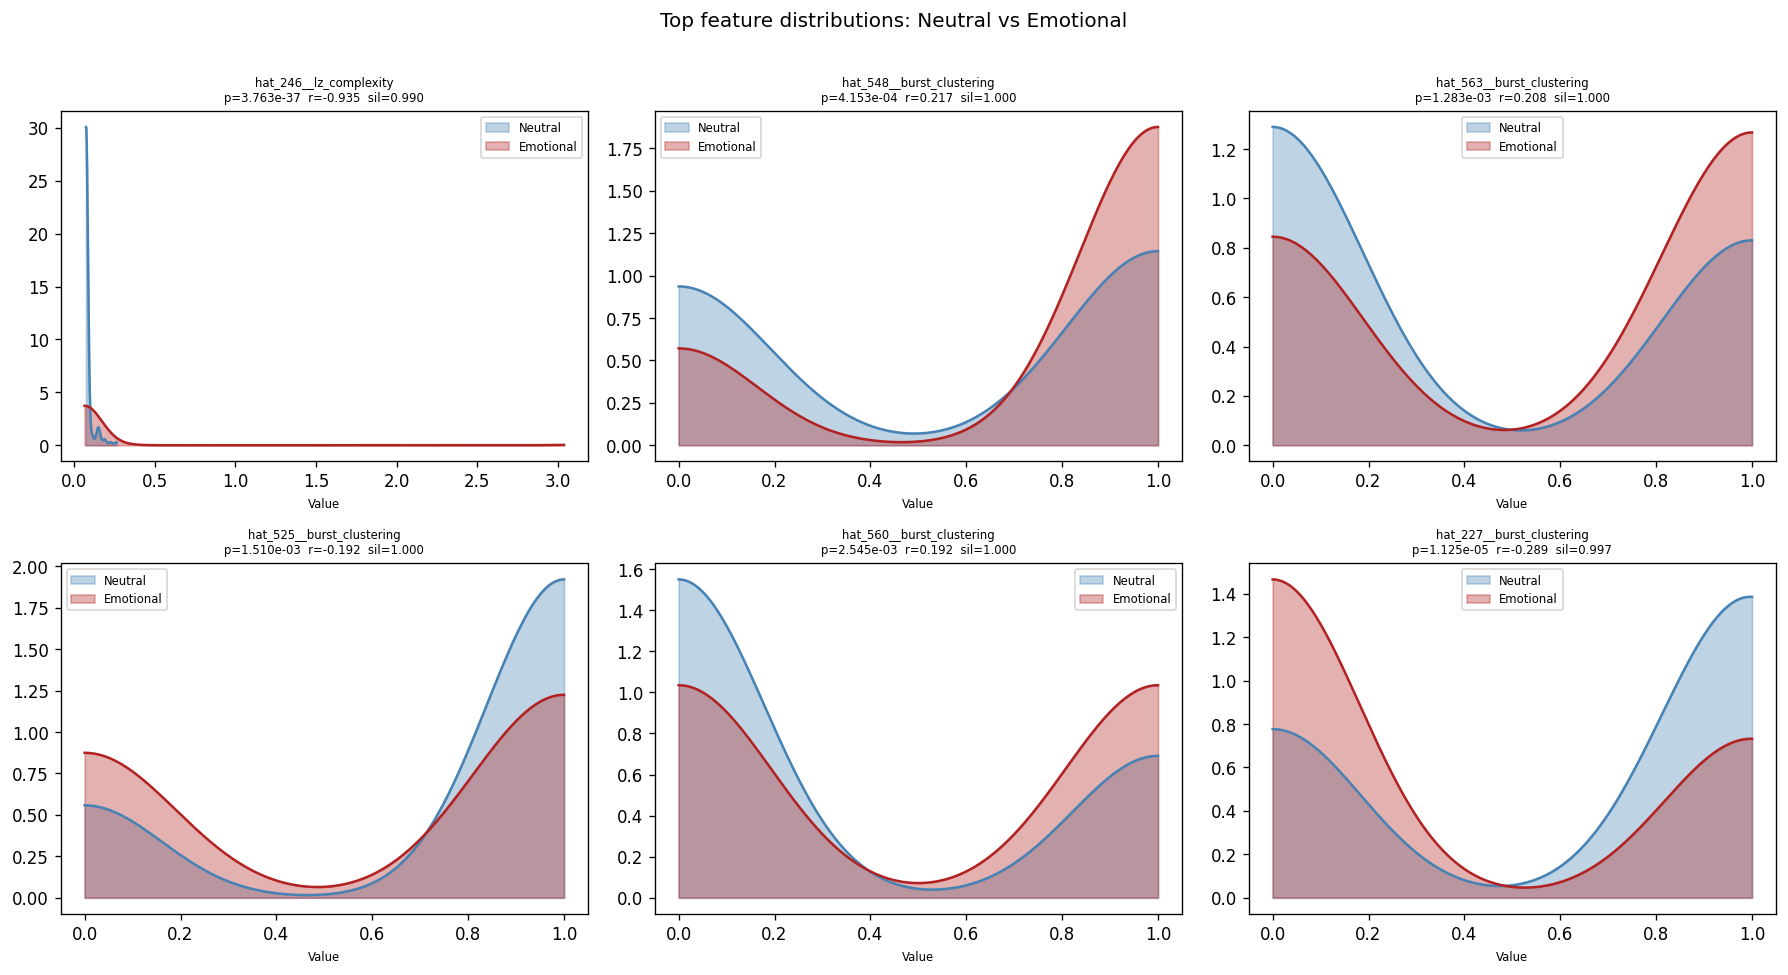

In [27]:
from scipy.stats import gaussian_kde

TOP_PLOT = 6
plot_features = ranking.head(TOP_PLOT)['feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for i, feat in enumerate(plot_features):
    ax = axes[i]
    n_vals_f = X_raw[feat][y == 0].dropna().values
    e_vals_f = X_raw[feat][y == 1].dropna().values

    for vals, label, color in [
        (n_vals_f, 'Neutral',   'steelblue'),
        (e_vals_f, 'Emotional', 'firebrick'),
    ]:
        if len(vals) < 3:
            continue
        kde = gaussian_kde(vals, bw_method='scott')
        x_range = np.linspace(vals.min(), vals.max(), 200)
        ax.fill_between(x_range, kde(x_range), alpha=0.35, color=color, label=label)
        ax.plot(x_range, kde(x_range), color=color, lw=1.5)

    # Get stats from ranking
    row = ranking[ranking.feature == feat].iloc[0]
    ax.set_title(f'{feat}\np={row.p:.3e}  r={row.effect_r:.3f}  sil={row.silhouette:.3f}',
                 fontsize=7)
    ax.set_xlabel('Value', fontsize=7)
    ax.legend(fontsize=7)

plt.suptitle('Top feature distributions: Neutral vs Emotional', fontsize=12, y=1.01)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_top_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 15 — Summary table

The final output: which features survive both univariate screening and clustering,
ranked by composite score. These are the indicators to carry forward.

In [28]:
summary = ranking.copy()
summary['indicator'] = summary.feature.apply(lambda f: parse_feature(f)[0])
summary['metric']    = summary.feature.apply(lambda f: parse_feature(f)[1])

# Flag if length-confounded: metrics NOT normalised by duration
non_normalised = ['variance', 'p90_p10', 'lz_complexity', 'perm_entropy']
summary['length_sensitive'] = summary.metric.isin(non_normalised) & LENGTH_CONFOUNDED

final_cols = ['composite_rank','indicator','metric','p','effect_r','direction',
              'silhouette','ari','purity','length_sensitive']
print('=== Final metric ranking (top 40) ===')
print(summary.head(40)[final_cols].to_string(index=False, float_format='{:.4f}'.format))

summary[final_cols].to_csv(BASE_DIR / 'final_metric_ranking.csv', index=False)
print(f'\nSaved → {BASE_DIR}/final_metric_ranking.csv')

=== Final metric ranking (top 40) ===
 composite_rank        indicator           metric      p  effect_r direction  silhouette     ari  purity  length_sensitive
       327.5000          hat_246    lz_complexity 0.0000   -0.9347        ↑E      0.9901  0.0000  0.7510              True
       348.5000          hat_548 burst_clustering 0.0004    0.2167        ↑E      1.0000  0.0433  0.6204             False
       359.5000          hat_563 burst_clustering 0.0013    0.2083        ↑E      1.0000  0.0394  0.6042             False
       363.0000          hat_525 burst_clustering 0.0015   -0.1917        ↓E      1.0000  0.0332  0.6100             False
       371.0000          hat_560 burst_clustering 0.0025    0.1917        ↑E      1.0000  0.0328  0.5995             False
       377.5000          hat_227 burst_clustering 0.0000   -0.2892        ↓E      0.9970  0.0913  0.6543             False
       382.0000      hat_HRTIMER    lz_complexity 0.0000   -0.9833        ↓E      0.9752  0.0000  0.7

## 16 — Per-indicator clustering: all metrics jointly

For each HAT indicator, collect all 10 of its metrics as a mini feature vector
(one row per trial, 10 columns = the 10 metrics for that indicator).
Then:
- Fit **k-means k=2** and a **2-component GMM**
- Score against ground-truth labels (ARI, accuracy, silhouette)
- This tells you: *as a whole, does this indicator's multi-dimensional signature
  separate emotional from neutral?*

The per-indicator result is distinct from per-metric: a single metric might not
separate cleanly, but the joint 10-D fingerprint of an indicator might.

In [29]:
# Build indicator → list of metric columns mapping
def get_indicator_metric_cols(feat_cols):
    """Return dict: indicator_name → [col1, col2, ...] (all 10 metric cols for it)."""
    ind_map = defaultdict(list)
    for col in feat_cols:
        indicator, metric = parse_feature(col)
        if metric in METRIC_NAMES:
            ind_map[indicator].append(col)
    return dict(ind_map)

ind_map = get_indicator_metric_cols(feat_cols)
print(f'Indicators found: {len(ind_map)}')
for ind, cols in sorted(ind_map.items()):
    print(f'  {ind[:50]:50s}  {len(cols)} metrics')

Indicators found: 496
  LLC-load-misses                                     9 metrics
  branch-instructions                                 9 metrics
  branch-misses                                       9 metrics
  cache-misses                                        9 metrics
  cache-references                                    9 metrics
  context-switches                                    9 metrics
  cpu-clock                                           9 metrics
  cpu-migrations                                      9 metrics
  cpu_freq_mean                                       9 metrics
  cycles                                              9 metrics
  dTLB-load-misses                                    9 metrics
  hat_0                                               1 metrics
  hat_120                                             1 metrics
  hat_121                                             1 metrics
  hat_122                                             1 metrics
  hat_123         

In [30]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.preprocessing import StandardScaler


def cluster_and_score(X_ind: np.ndarray, y_true: np.ndarray, name: str) -> dict:
    """
    Fit k=2 KMeans and GMM on X_ind, compare both to ground truth.
    Returns a dict of scores.
    """
    result = {'indicator': name, 'n_metrics': X_ind.shape[1]}

    # Drop rows with NaN
    mask = np.isfinite(X_ind).all(axis=1)
    Xc = X_ind[mask]
    yc = y_true[mask]
    result['n_samples'] = int(mask.sum())

    if len(np.unique(yc)) < 2 or Xc.shape[0] < 10:
        result.update({'km_ari': np.nan, 'km_acc': np.nan, 'km_sil': np.nan,
                       'gmm_ari': np.nan, 'gmm_acc': np.nan, 'gmm_sil': np.nan,
                       'km_n_acc': np.nan, 'km_e_acc': np.nan,
                       'gmm_n_acc': np.nan, 'gmm_e_acc': np.nan})
        return result

    sc = StandardScaler()
    Xs = sc.fit_transform(Xc)

    for tag, model in [('km',  KMeans(n_clusters=2, random_state=42, n_init=20)),
                       ('gmm', GaussianMixture(n_components=2, covariance_type='full',
                                               random_state=42, n_init=10))]:
        lbl = model.fit_predict(Xs)

        ari = adjusted_rand_score(yc, lbl)
        sil = silhouette_score(Xs, lbl) if len(np.unique(lbl)) > 1 else np.nan

        # Align cluster label orientation to ground truth
        acc_direct  = (lbl == yc).mean()
        acc_flipped = (1 - lbl == yc).mean()
        if acc_flipped > acc_direct:
            lbl = 1 - lbl
        acc = (lbl == yc).mean()

        # Per-class accuracy
        n_acc = (lbl[yc == 0] == 0).mean() if (yc == 0).sum() > 0 else np.nan
        e_acc = (lbl[yc == 1] == 1).mean() if (yc == 1).sum() > 0 else np.nan

        result.update({
            f'{tag}_ari':   ari,
            f'{tag}_acc':   acc,
            f'{tag}_sil':   sil,
            f'{tag}_n_acc': n_acc,
            f'{tag}_e_acc': e_acc,
        })

    return result


# ── Run per-indicator multi-metric clustering ──
ind_results = []
for indicator, cols in ind_map.items():
    X_ind = X_raw[cols].values.astype(float)
    res = cluster_and_score(X_ind, y, indicator)
    ind_results.append(res)

ind_df = pd.DataFrame(ind_results).sort_values('gmm_ari', ascending=False).reset_index(drop=True)
print(f'Per-indicator clustering complete: {len(ind_df)} indicators')
print()
print('=== Per-indicator results (sorted by GMM ARI) ===')
show_cols = ['indicator','n_metrics','n_samples',
             'km_ari','km_acc','km_n_acc','km_e_acc','km_sil',
             'gmm_ari','gmm_acc','gmm_n_acc','gmm_e_acc','gmm_sil']
print(ind_df[show_cols].to_string(index=False, float_format='{:.3f}'.format))
ind_df.to_csv(BASE_DIR / 'per_indicator_clustering.csv', index=False)
print(f'\nSaved → {BASE_DIR}/per_indicator_clustering.csv')

Per-indicator clustering complete: 496 indicators

=== Per-indicator results (sorted by GMM ARI) ===
              indicator  n_metrics  n_samples  km_ari  km_acc  km_n_acc  km_e_acc  km_sil  gmm_ari  gmm_acc  gmm_n_acc  gmm_e_acc  gmm_sil
                hat_LOC          9        240   0.950   0.988     0.975     1.000   0.352    1.000    1.000      1.000      1.000    0.353
       dTLB-load-misses          9        240   1.000   1.000     1.000     1.000   0.670    1.000    1.000      1.000      1.000    0.670
                hat_465          1        240   0.983   0.996     1.000     0.992   0.964    0.983    0.996      1.000      0.992    0.964
                hat_454          1        240   0.983   0.996     1.000     0.992   0.964    0.983    0.996      1.000      0.992    0.964
                hat_461          1        240   0.983   0.996     1.000     0.992   0.964    0.983    0.996      1.000      0.992    0.964
                hat_460          1        240   0.983   0.996    

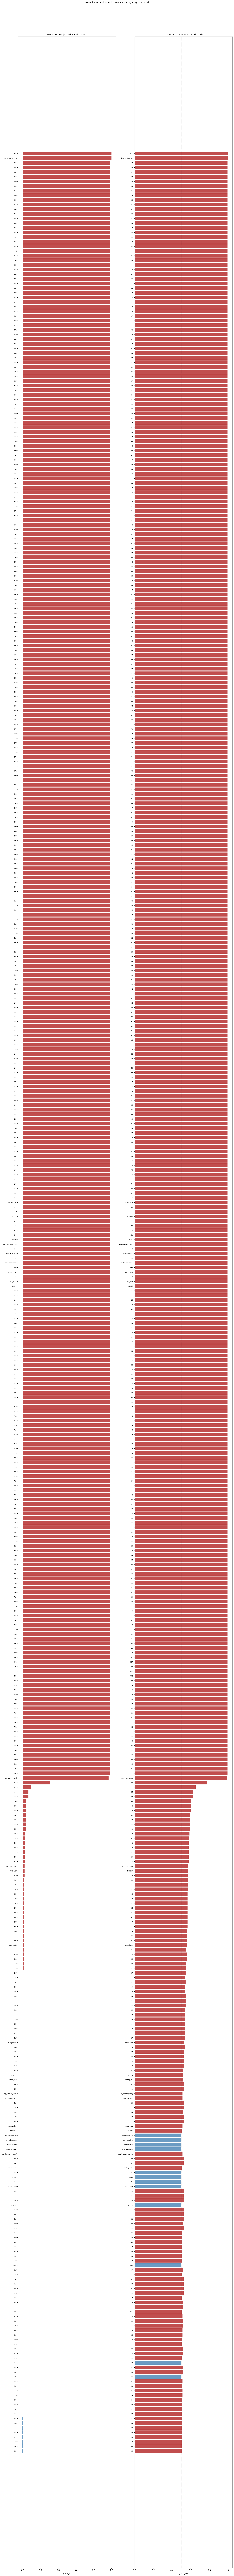

In [31]:
# Visualise: horizontal bar chart of GMM accuracy per indicator
plot_df = ind_df.dropna(subset=['gmm_acc']).copy()
plot_df['short_name'] = plot_df.indicator.apply(lambda s: s.replace('hat_','').replace('irq:','').replace('power/','').replace('msr/','')[:40])

fig, axes = plt.subplots(1, 2, figsize=(16, max(6, len(plot_df) * 0.35)))

for ax, col, title, threshold in [
    (axes[0], 'gmm_ari',  'GMM ARI (Adjusted Rand Index)', 0),
    (axes[1], 'gmm_acc',  'GMM Accuracy vs ground truth',  0.5),
]:
    vals = plot_df[col].values
    colors = ['firebrick' if v > threshold else 'steelblue' for v in vals]
    ax.barh(range(len(plot_df)), vals, color=colors, alpha=0.8)
    ax.set_yticks(range(len(plot_df)))
    ax.set_yticklabels(plot_df.short_name, fontsize=7)
    ax.invert_yaxis()
    ax.axvline(threshold, color='black', lw=0.8, ls='--')
    ax.set_xlabel(col)
    ax.set_title(title)

plt.suptitle('Per-indicator multi-metric GMM clustering vs ground truth', fontsize=11, y=1.01)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_per_indicator_gmm.png', dpi=150, bbox_inches='tight')
plt.show()

## 17 — Per-indicator, per-metric clustering

Now the finest granularity: for every (indicator, metric) pair, cluster on that
single scalar alone (k=2 KMeans) and score against ground truth.

This gives us a full **indicator × metric** result table — the definitive answer
to *which specific measurement on which specific indicator* drives the separation.

We then visualise this as a heatmap (indicators × metrics, coloured by ARI or accuracy),
making it immediately clear where the signal lives.

In [32]:
per_cell_results = []

for indicator, cols in ind_map.items():
    for col in cols:
        _, metric = parse_feature(col)
        x1d = X_raw[[col]].values.astype(float)
        res = cluster_and_score(x1d, y, indicator)
        res['metric'] = metric
        res['feature'] = col
        per_cell_results.append(res)

cell_df = pd.DataFrame(per_cell_results)
print(f'Per-cell results: {len(cell_df)} (indicator × metric combinations)')

# Also retrieve MWU p and effect size from earlier
cell_df = cell_df.merge(
    mwu_df[['feature','p','effect_r','direction']],
    on='feature', how='left'
)

cell_df_sorted = cell_df.sort_values('gmm_ari', ascending=False).reset_index(drop=True)
print('\n=== Top 40 (indicator, metric) cells by GMM ARI ===')
show = ['indicator','metric','gmm_ari','gmm_acc','gmm_n_acc','gmm_e_acc','p','effect_r','direction']
print(cell_df_sorted.head(40)[show].to_string(index=False, float_format='{:.4f}'.format))
cell_df_sorted.to_csv(BASE_DIR / 'per_indicator_per_metric.csv', index=False)
print(f'\nSaved → {BASE_DIR}/per_indicator_per_metric.csv')

Per-cell results: 1729 (indicator × metric combinations)

=== Top 40 (indicator, metric) cells by GMM ARI ===
indicator        metric  gmm_ari  gmm_acc  gmm_n_acc  gmm_e_acc      p  effect_r direction
  hat_LOC     mean_rate   1.0000   1.0000     1.0000     1.0000 0.0000   -1.0000        ↓E
  hat_CAL     mean_rate   1.0000   1.0000     1.0000     1.0000 0.0000   -1.0000        ↓E
  hat_190 lz_complexity   0.9833   0.9958     1.0000     0.9917 0.0000   -1.0000        ↓E
  hat_603 lz_complexity   0.9833   0.9958     1.0000     0.9917 0.0000   -1.0000        ↓E
  hat_593 lz_complexity   0.9833   0.9958     1.0000     0.9917 0.0000   -1.0000        ↓E
  hat_594 lz_complexity   0.9833   0.9958     1.0000     0.9917 0.0000   -1.0000        ↓E
  hat_595 lz_complexity   0.9833   0.9958     1.0000     0.9917 0.0000   -1.0000        ↓E
  hat_596 lz_complexity   0.9833   0.9958     1.0000     0.9917 0.0000   -1.0000        ↓E
  hat_597 lz_complexity   0.9833   0.9958     1.0000     0.9917 0.0000 

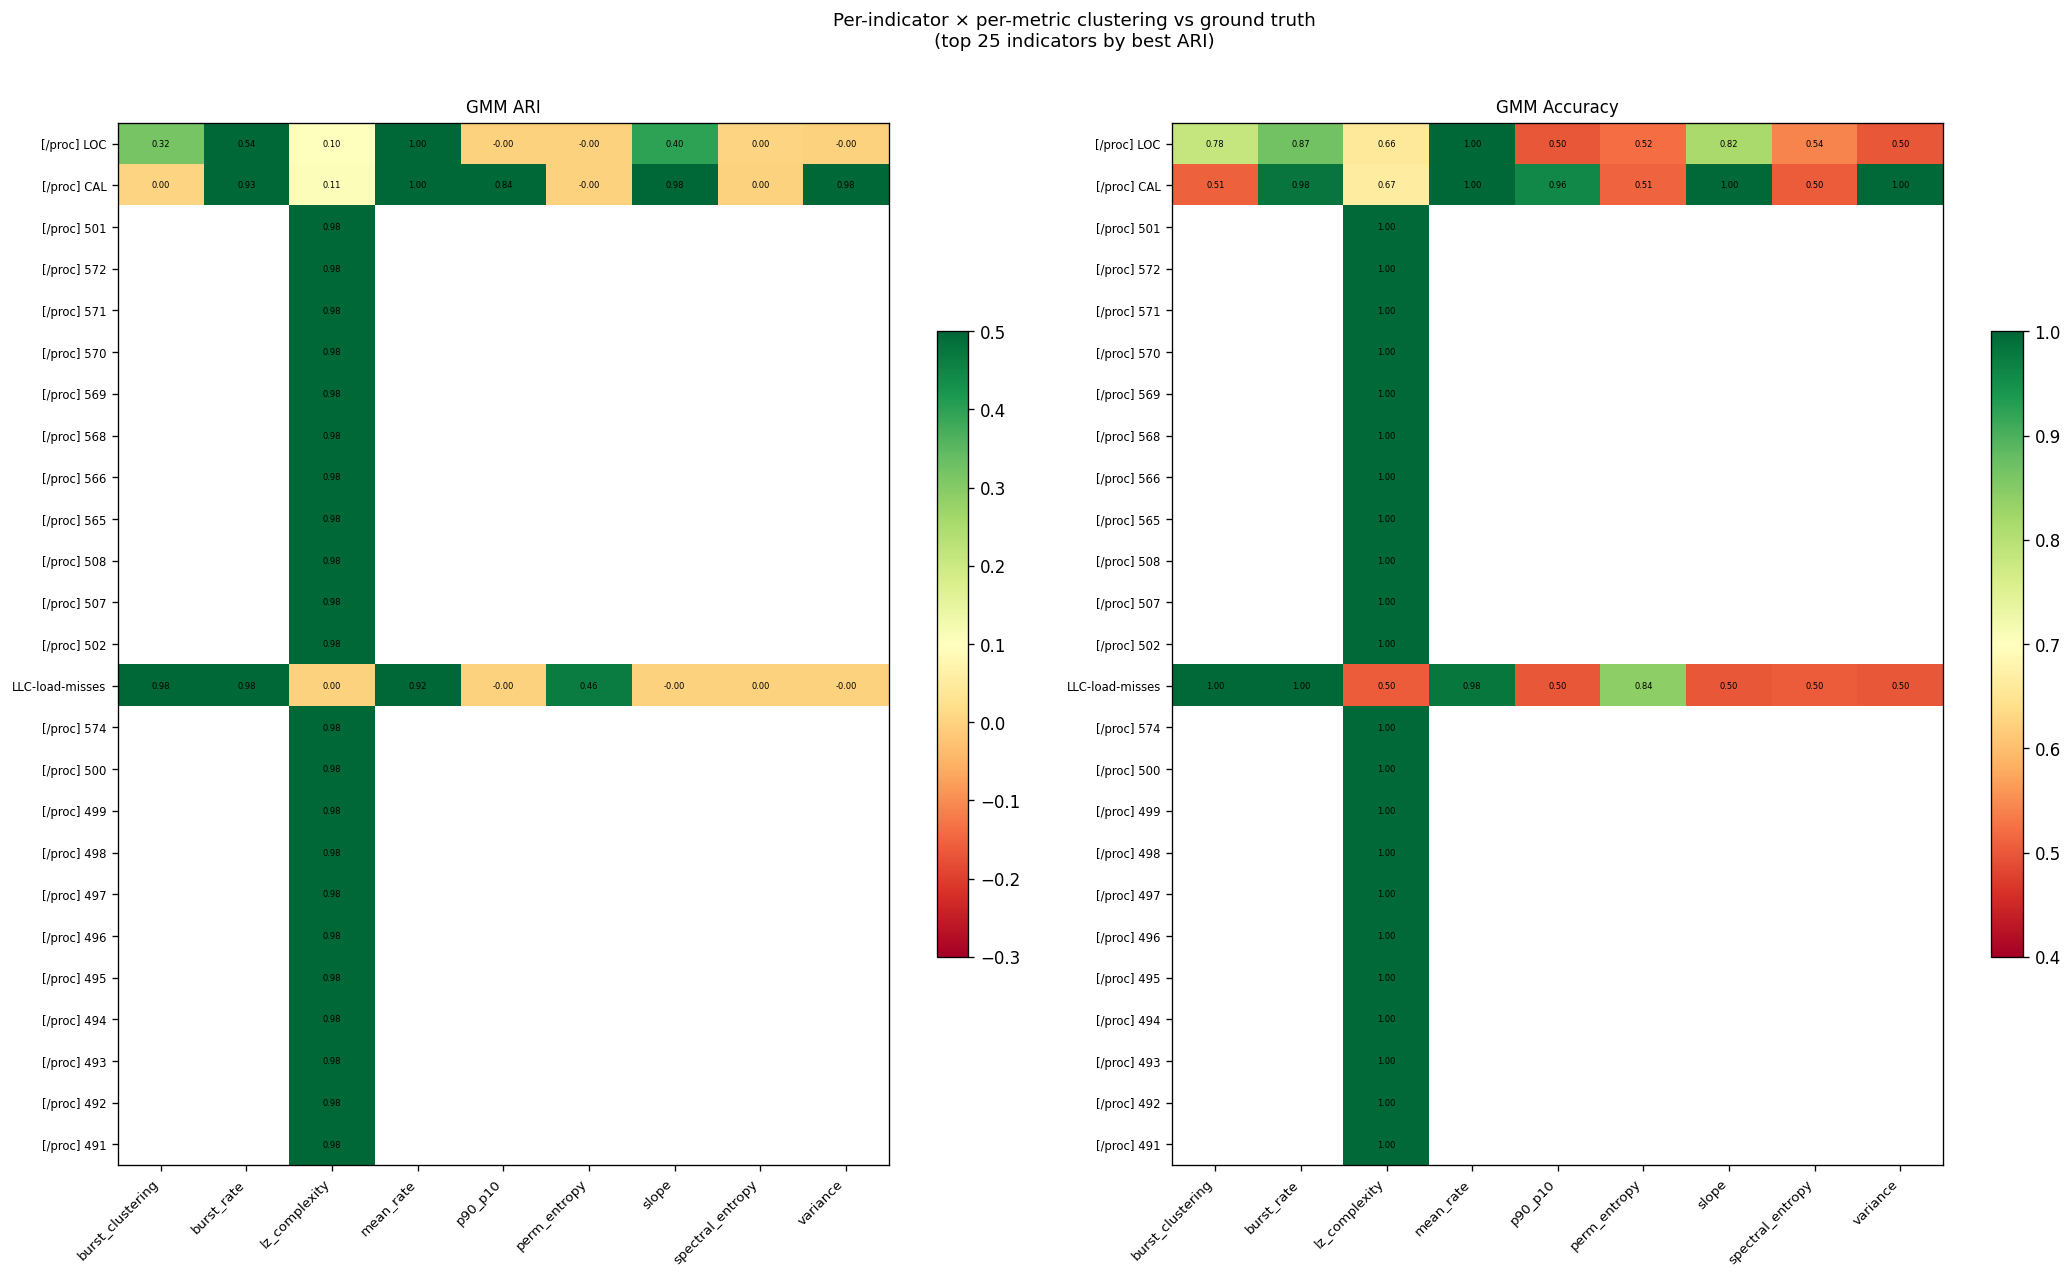

In [33]:
# ── Heatmap: indicators × metrics, coloured by GMM ARI ──
# Show top 25 indicators by their best single-metric ARI

best_ari_per_ind = (
    cell_df.groupby('indicator')['gmm_ari']
    .max().sort_values(ascending=False)
    .head(25).index.tolist()
)

pivot_ari = cell_df[cell_df.indicator.isin(best_ari_per_ind)].pivot_table(
    index='indicator', columns='metric', values='gmm_ari', aggfunc='first'
).reindex(index=best_ari_per_ind)

pivot_acc = cell_df[cell_df.indicator.isin(best_ari_per_ind)].pivot_table(
    index='indicator', columns='metric', values='gmm_acc', aggfunc='first'
).reindex(index=best_ari_per_ind)

# Clean up indicator names for display
def short_ind(s):
    return (s.replace('hat_','[/proc] ')
             .replace('irq:','').replace('power/','pwr/')
             .replace('msr/','msr/').replace('stalled-cycles-','stall-'))[:45]

row_labels = [short_ind(s) for s in best_ari_per_ind]

fig, axes = plt.subplots(1, 2, figsize=(18, max(8, len(best_ari_per_ind) * 0.42)))

for ax, pivot, title, vmin, vmax, cmap in [
    (axes[0], pivot_ari, 'GMM ARI',      -0.3, 0.5, 'RdYlGn'),
    (axes[1], pivot_acc, 'GMM Accuracy',  0.4, 1.0, 'RdYlGn'),
]:
    im = ax.imshow(pivot.values.astype(float), cmap=cmap, vmin=vmin, vmax=vmax, aspect='auto')
    plt.colorbar(im, ax=ax, shrink=0.6)
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns, rotation=45, ha='right', fontsize=8)
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(row_labels, fontsize=7)
    ax.set_title(title, fontsize=10)

    # Annotate cells with value
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            val = pivot.values[i, j]
            if np.isfinite(val):
                ax.text(j, i, f'{val:.2f}', ha='center', va='center',
                        fontsize=5, color='black')

plt.suptitle('Per-indicator × per-metric clustering vs ground truth\n(top 25 indicators by best ARI)',
             fontsize=11, y=1.01)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_indicator_metric_cluster_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 18 — Which metrics differ most between conditions?

Aggregate across all indicators: for each of the 10 metric types, how often
does it produce a high-ARI clustering? And what is the mean effect size?

This answers: *regardless of which indicator you look at, which measurement
approach (burst_clustering, mean_rate, spectral_entropy, …) most reliably
discriminates emotional from neutral computation?*

We show:
1. Mean and max GMM ARI per metric type (averaged over all indicators)
2. Mean absolute effect size |r| per metric type
3. Hit rate: fraction of indicators where that metric achieves ARI > 0.1
4. Distribution plots of the top-2 metric types

In [34]:
metric_summary = []
for m in METRIC_NAMES:
    rows = cell_df[cell_df.metric == m].dropna(subset=['gmm_ari'])
    if len(rows) == 0:
        continue
    metric_summary.append({
        'metric':          m,
        'n_indicators':    len(rows),
        'mean_gmm_ari':    rows.gmm_ari.mean(),
        'max_gmm_ari':     rows.gmm_ari.max(),
        'mean_gmm_acc':    rows.gmm_acc.mean(),
        'hit_rate_01':     (rows.gmm_ari > 0.10).mean(),  # fraction with ARI > 0.10
        'hit_rate_05':     (rows.gmm_ari > 0.05).mean(),
        'mean_abs_effect': rows.effect_r.abs().mean() if 'effect_r' in rows else np.nan,
        'best_indicator':  rows.sort_values('gmm_ari', ascending=False).iloc[0]['indicator'],
    })

msummary_df = pd.DataFrame(metric_summary).sort_values('mean_gmm_ari', ascending=False).reset_index(drop=True)
print('=== Metric type discriminability (across all indicators) ===')
print(msummary_df.drop(columns=['best_indicator']).to_string(index=False, float_format='{:.4f}'.format))
print()
print('Best indicator per metric:')
for _, row in msummary_df.iterrows():
    print(f'  {row.metric:20s}  best: {row.best_indicator[:60]}')

=== Metric type discriminability (across all indicators) ===
          metric  n_indicators  mean_gmm_ari  max_gmm_ari  mean_gmm_acc  hit_rate_01  hit_rate_05  mean_abs_effect
   lz_complexity           496        0.6920       0.9833        0.8581       0.7077       0.7198           0.8403
       mean_rate           156        0.1338       1.0000        0.5897       0.1538       0.1538           0.2349
      burst_rate           156        0.0496       0.9833        0.5514       0.0513       0.0513           0.1542
           slope           156        0.0362       0.9833        0.5423       0.0385       0.0385           0.1733
burst_clustering           154        0.0309       0.9833        0.5475       0.0455       0.0519           0.1364
        variance           156        0.0237       0.9833        0.5296       0.0321       0.0321           0.1647
         p90_p10            38        0.0235       0.8396        0.5241       0.0263       0.0263           0.4195
    perm_entropy   

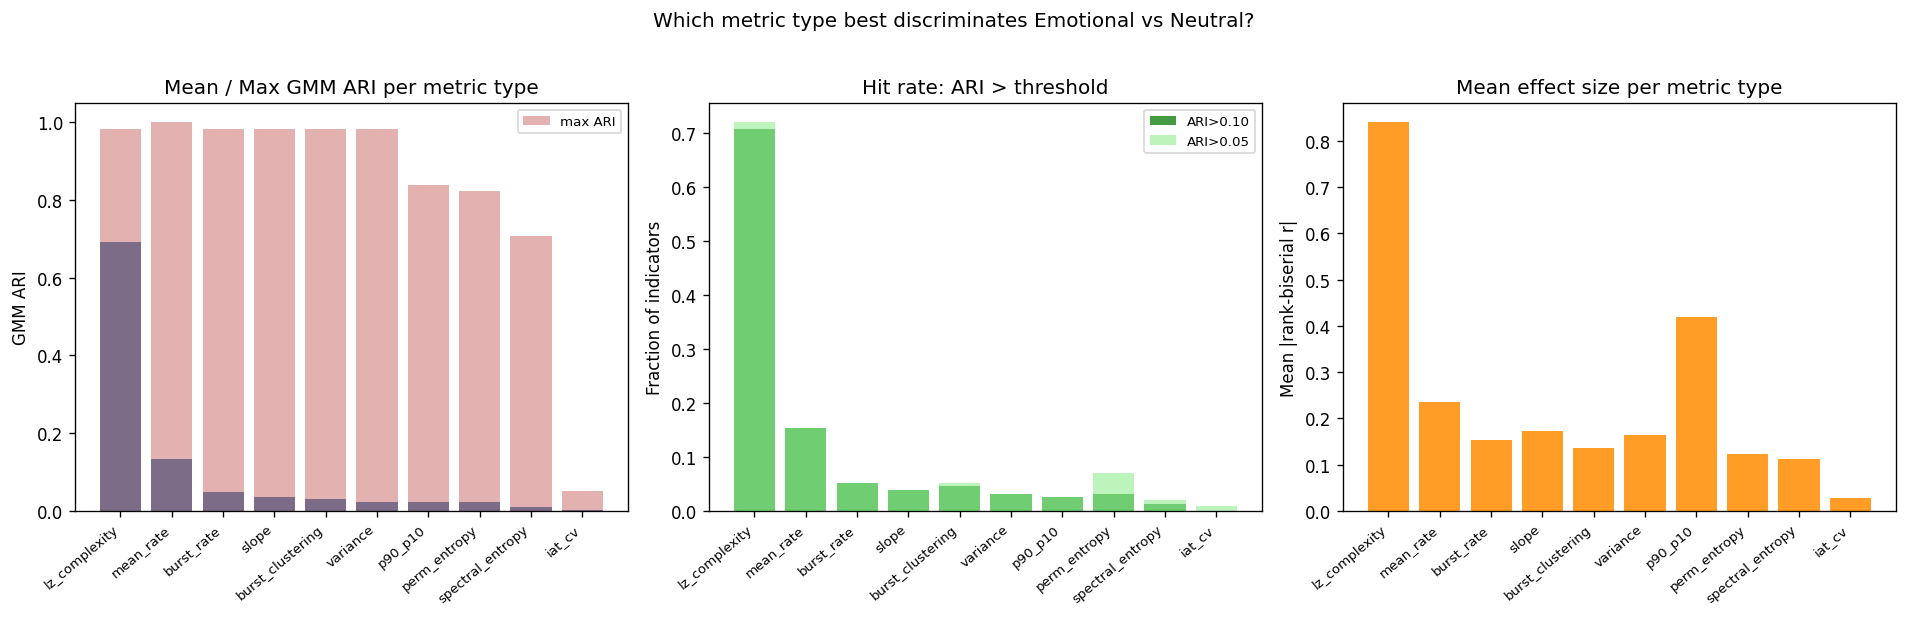

In [35]:
# Bar chart: mean GMM ARI and hit rate per metric type
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

order = msummary_df['metric'].tolist()
x = np.arange(len(order))

axes[0].bar(x, msummary_df['mean_gmm_ari'], color='steelblue', alpha=0.85)
axes[0].bar(x, msummary_df['max_gmm_ari'],  color='firebrick', alpha=0.35, label='max ARI')
axes[0].set_xticks(x); axes[0].set_xticklabels(order, rotation=40, ha='right', fontsize=8)
axes[0].set_ylabel('GMM ARI'); axes[0].set_title('Mean / Max GMM ARI per metric type')
axes[0].axhline(0, color='gray', lw=0.5, ls='--')
axes[0].legend(fontsize=8)

axes[1].bar(x, msummary_df['hit_rate_01'], color='forestgreen', alpha=0.85, label='ARI>0.10')
axes[1].bar(x, msummary_df['hit_rate_05'], color='lightgreen',  alpha=0.6,  label='ARI>0.05')
axes[1].set_xticks(x); axes[1].set_xticklabels(order, rotation=40, ha='right', fontsize=8)
axes[1].set_ylabel('Fraction of indicators'); axes[1].set_title('Hit rate: ARI > threshold')
axes[1].legend(fontsize=8)

axes[2].bar(x, msummary_df['mean_abs_effect'].fillna(0), color='darkorange', alpha=0.85)
axes[2].set_xticks(x); axes[2].set_xticklabels(order, rotation=40, ha='right', fontsize=8)
axes[2].set_ylabel('Mean |rank-biserial r|'); axes[2].set_title('Mean effect size per metric type')

plt.suptitle('Which metric type best discriminates Emotional vs Neutral?', fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_metric_discriminability.png', dpi=150, bbox_inches='tight')
plt.show()

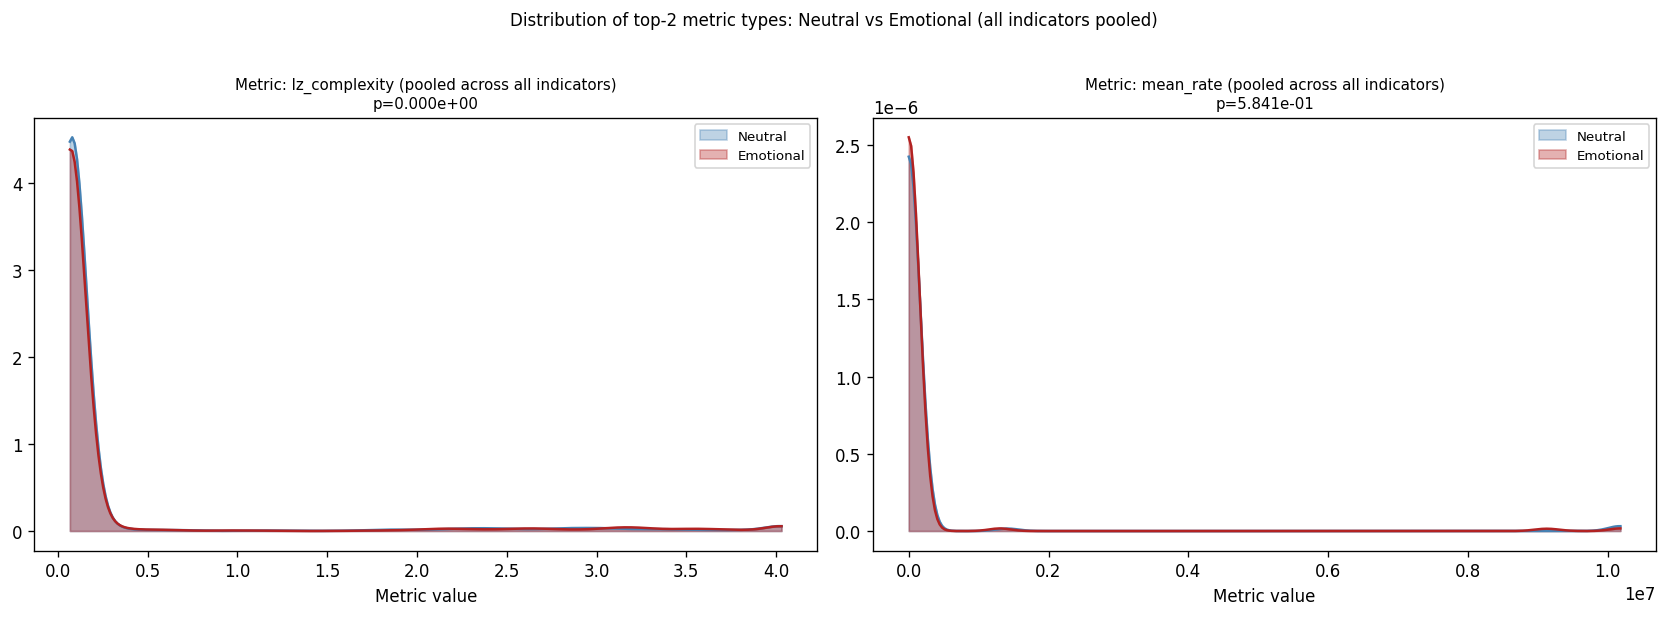

In [36]:
# ── Distribution comparison for top-2 metric types (across all indicators, pooled) ──
from scipy.stats import gaussian_kde

top2_metrics = msummary_df.head(2)['metric'].tolist()
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, m in zip(axes, top2_metrics):
    m_cols = [c for c in feat_cols if c.endswith(f'__{m}')]
    # Pool all indicators for this metric type
    n_pool = X_raw.loc[y == 0, m_cols].values.ravel()
    e_pool = X_raw.loc[y == 1, m_cols].values.ravel()
    n_pool = n_pool[np.isfinite(n_pool)]
    e_pool = e_pool[np.isfinite(e_pool)]

    # Clip extreme outliers for display (1st–99th percentile)
    lo = min(np.percentile(n_pool, 1), np.percentile(e_pool, 1))
    hi = max(np.percentile(n_pool, 99), np.percentile(e_pool, 99))
    xr = np.linspace(lo, hi, 300)

    for vals, label, color in [
        (n_pool, 'Neutral',   'steelblue'),
        (e_pool, 'Emotional', 'firebrick'),
    ]:
        kde = gaussian_kde(np.clip(vals, lo, hi), bw_method='scott')
        ax.fill_between(xr, kde(xr), alpha=0.35, color=color, label=label)
        ax.plot(xr, kde(xr), color=color, lw=1.5)

    # Report Mann-Whitney over pooled values
    _, p_pool = sp_stats.mannwhitneyu(n_pool, e_pool, alternative='two-sided')
    ax.set_title(f'Metric: {m} (pooled across all indicators)\np={p_pool:.3e}', fontsize=9)
    ax.set_xlabel('Metric value')
    ax.legend(fontsize=8)

plt.suptitle('Distribution of top-2 metric types: Neutral vs Emotional (all indicators pooled)',
             fontsize=10, y=1.02)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_top_metric_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 19 — Confusion matrices for best-performing (indicator, metric) pairs

For the top N cells by GMM ARI, show the full confusion matrix:
how many neutral trials were assigned to each cluster,
how many emotional trials were assigned to each cluster.

This shows whether an indicator separates *both* conditions well,
or only one (e.g. perfectly identifies emotional but misclassifies neutral).

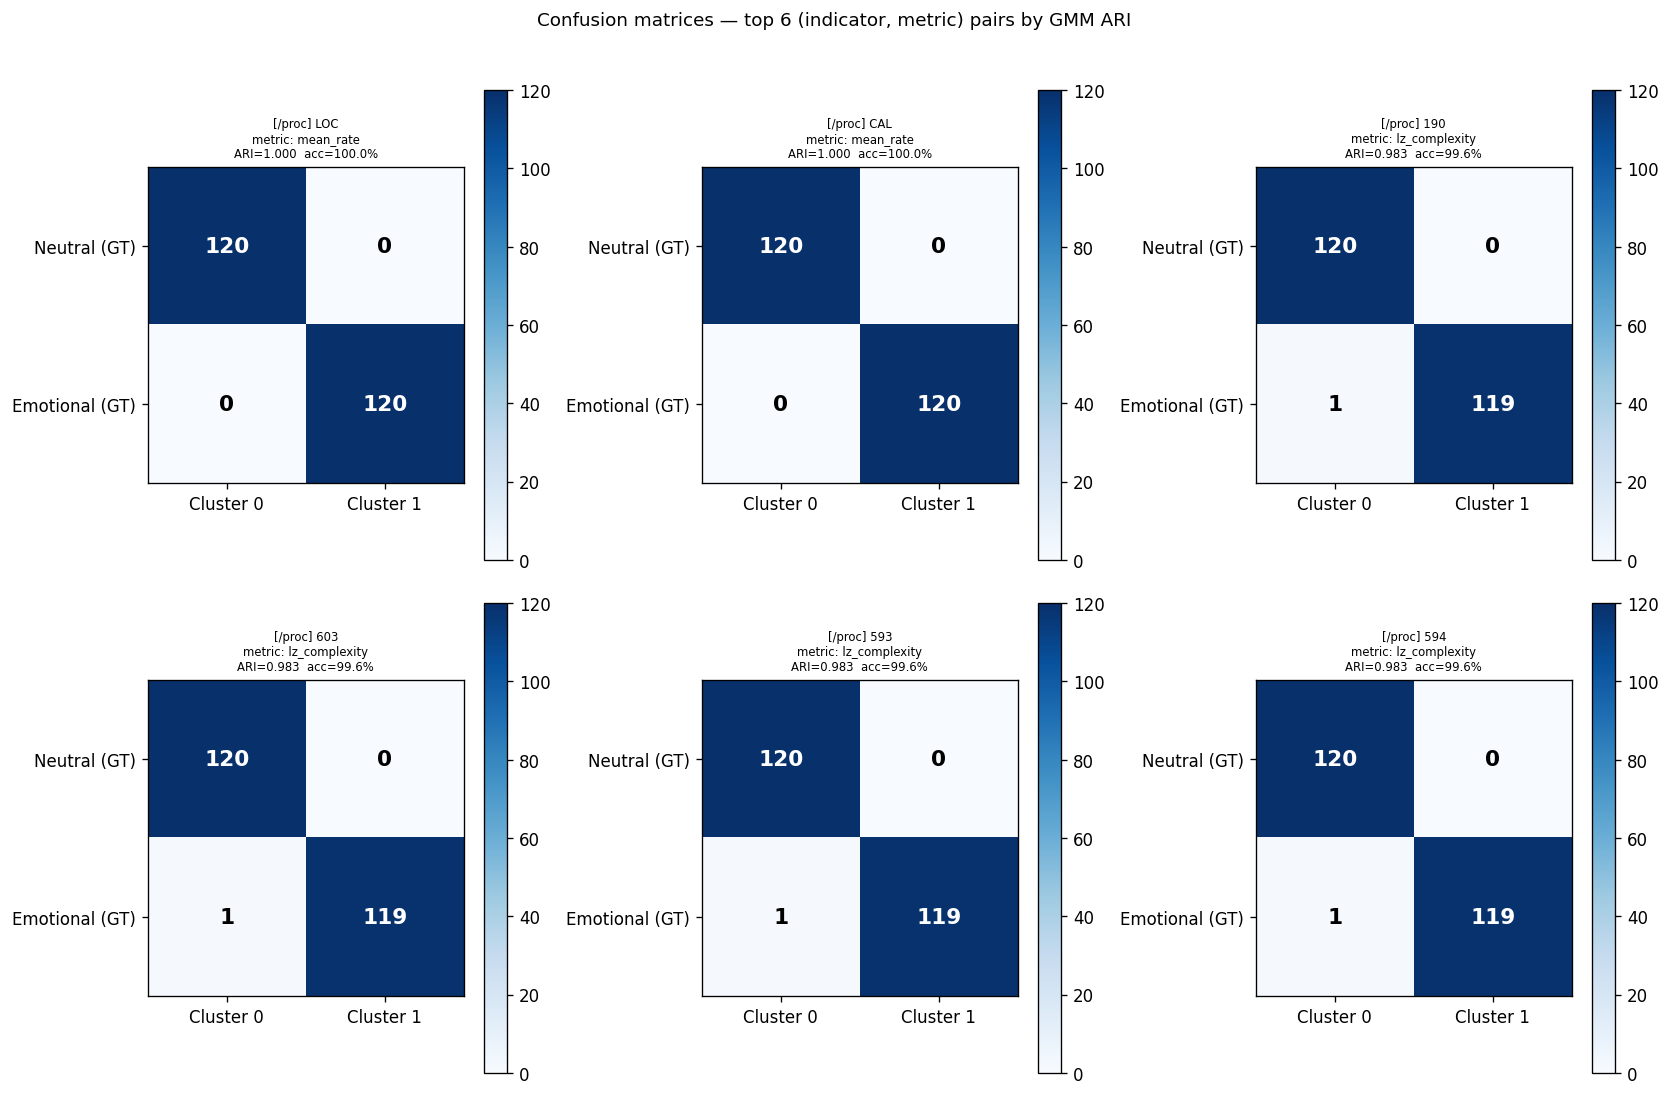

In [37]:
TOP_CM = 6  # how many confusion matrices to plot
top_cells = cell_df_sorted.head(TOP_CM)

fig, axes = plt.subplots(2, 3, figsize=(14, 9))
axes = axes.ravel()

for i, (_, row) in enumerate(top_cells.iterrows()):
    ax = axes[i]
    col = row['feature']
    x1d = X_raw[[col]].values.astype(float)
    mask = np.isfinite(x1d).ravel()
    Xc = x1d[mask]; yc = y[mask]

    sc = StandardScaler()
    Xs = sc.fit_transform(Xc)
    gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42, n_init=10)
    lbl = gmm.fit_predict(Xs)

    # Align orientation
    if (1 - lbl == yc).mean() > (lbl == yc).mean():
        lbl = 1 - lbl

    cm = confusion_matrix(yc, lbl)
    # rows: true label (0=neutral, 1=emotional), cols: predicted cluster
    im = ax.imshow(cm, cmap='Blues', vmin=0)
    plt.colorbar(im, ax=ax)
    ax.set_xticks([0, 1]); ax.set_xticklabels(['Cluster 0', 'Cluster 1'])
    ax.set_yticks([0, 1]); ax.set_yticklabels(['Neutral (GT)', 'Emotional (GT)'])
    for r in range(2):
        for c in range(2):
            ax.text(c, r, str(cm[r, c]), ha='center', va='center',
                    fontsize=13, fontweight='bold',
                    color='white' if cm[r, c] > cm.max() * 0.5 else 'black')
    ind_short = short_ind(row['indicator'])
    ax.set_title(
        f'{ind_short}\nmetric: {row["metric"]}\n'
        f'ARI={row["gmm_ari"]:.3f}  acc={row["gmm_acc"]:.1%}',
        fontsize=7
    )

plt.suptitle(f'Confusion matrices — top {TOP_CM} (indicator, metric) pairs by GMM ARI',
             fontsize=11, y=1.01)
plt.tight_layout()
plt.savefig(BASE_DIR / 'fig_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

## 20 — Final results table

One unified table: every (indicator, metric) pair, with:
- GMM ARI and accuracy (overall + per condition)
- MWU p-value and effect size
- Length-sensitivity flag
- Sorted by GMM ARI descending

This is the primary output for thesis reporting.

In [38]:
final = cell_df_sorted[[
    'indicator','metric','feature',
    'gmm_ari','gmm_acc','gmm_n_acc','gmm_e_acc','gmm_sil',
    'km_ari','km_acc',
    'p','effect_r','direction','n_samples'
]].copy()

non_normalised = ['variance', 'p90_p10', 'lz_complexity', 'perm_entropy']
final['length_sensitive'] = final.metric.isin(non_normalised) & LENGTH_CONFOUNDED

print('=== Full (indicator × metric) results — top 50 ===')
print(final.head(50).to_string(index=False, float_format='{:.4f}'.format))

final.to_csv(BASE_DIR / 'full_indicator_metric_results.csv', index=False)
print(f'\nSaved → {BASE_DIR}/full_indicator_metric_results.csv')

# Quick text summary
print('\n=== KEY FINDINGS ===')
top5 = final.head(5)
for _, r in top5.iterrows():
    flag = ' [LENGTH-SENSITIVE]' if r.length_sensitive else ''
    print(f'  {r.indicator[:35]:35s}  {r.metric:20s}  '
          f'ARI={r.gmm_ari:.3f}  acc={r.gmm_acc:.1%}  '
          f'p={r.p:.3e}  {r.direction}{flag}')

=== Full (indicator × metric) results — top 50 ===
indicator        metric                feature  gmm_ari  gmm_acc  gmm_n_acc  gmm_e_acc  gmm_sil  km_ari  km_acc      p  effect_r direction  n_samples  length_sensitive
  hat_LOC     mean_rate     hat_LOC__mean_rate   1.0000   1.0000     1.0000     1.0000   0.9565  1.0000  1.0000 0.0000   -1.0000        ↓E        240             False
  hat_CAL     mean_rate     hat_CAL__mean_rate   1.0000   1.0000     1.0000     1.0000   0.9537  1.0000  1.0000 0.0000   -1.0000        ↓E        240             False
  hat_190 lz_complexity hat_190__lz_complexity   0.9833   0.9958     1.0000     0.9917   0.9644  0.9833  0.9958 0.0000   -1.0000        ↓E        240              True
  hat_603 lz_complexity hat_603__lz_complexity   0.9833   0.9958     1.0000     0.9917   0.9644  0.9833  0.9958 0.0000   -1.0000        ↓E        240              True
  hat_593 lz_complexity hat_593__lz_complexity   0.9833   0.9958     1.0000     0.9917   0.9644  0.9833  0.99